In [28]:
!pip install hvplot panel bokeh --quiet


In [29]:
import pandas as pd
import hvplot.pandas
import panel as pn
pn.extension()


/tmp/ipython-input-1679668053.py:4: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


In [30]:

# Étape 2 : Lecture du fichier brut
df_ottawa = pd.read_csv("ottawa_2.csv")

# Harmonisation des dates (automatique)
if "Date/Time" in df_ottawa.columns or "Date" in df_ottawa.columns:
    col_date = "Date/Time" if "Date/Time" in df_ottawa.columns else "Date"
    try:
        df_ottawa["Date"] = pd.to_datetime(df_ottawa[col_date], infer_datetime_format=True, errors='coerce')
    except:
        df_ottawa["Date"] = df_ottawa[col_date].apply(lambda x: parser.parse(str(x)) if pd.notna(x) else pd.NaT)
else:
    raise KeyError("Aucune colonne de date trouvée.")

# Colonnes numériques à imputer
cols_cibles = ["Temp", "Precip", "Snow", "Pressure", "Gust"]
num_cols = [c for c in df_ottawa.columns if any(x in c for x in cols_cibles)]

# Étape 3 : Vérification avant imputation
print("Valeurs manquantes AVANT imputation (Ottawa):")
print(df_ottawa[num_cols].isna().sum())

# Étape 4 : Imputation par moyenne mobile
for col in num_cols:
    # 1️⃣ Imputation par moyenne mobile
    df_ottawa[col] = df_ottawa[col].fillna(df_ottawa[col].rolling(window=3, min_periods=1).mean())

    # 2️⃣ Si encore des valeurs manquantes, remplace par la moyenne globale
    if df_ottawa[col].isna().sum() > 0:
        df_ottawa[col] = df_ottawa[col].fillna(df_ottawa[col].mean())


# Étape 5 : Vérification après imputation
print("\nValeurs manquantes APRÈS imputation (Ottawa):")
print(df_ottawa[num_cols].isna().sum())

# Étape 6 : Sauvegarde du fichier imputé
df_ottawa.to_csv("ottawa_3.csv", index=False)
print("\n Fichier sauvegardé : ottawa_3.csv")

# Étape 7 : Visualisation interactive avant/après
ville = "Ottawa"
df_before = pd.read_csv("ottawa_2.csv")
df_after = pd.read_csv("ottawa_3.csv")

#  Conversion automatique des dates
for d in [df_before, df_after]:
    if "Date/Time" in d.columns:
        col_date = "Date/Time"
    elif "Date" in d.columns:
        col_date = "Date"
    else:
        raise KeyError("Aucune colonne de date trouvée.")
    try:
        d["Date"] = pd.to_datetime(d[col_date], infer_datetime_format=True, errors='coerce')
    except:
        d["Date"] = d[col_date].apply(lambda x: parser.parse(str(x)) if pd.notna(x) else pd.NaT)

# Variables disponibles
variables_ottawa = [v for v in df_ottawa.columns if any(x in v for x in cols_cibles)]
var_select = pn.widgets.Select(name="Variable climatique", options=variables_ottawa)

@pn.depends(var_select)
def plot_ottawa(var):
    df_before[var] = df_before[var].fillna(0)
    df_after[var] = df_after[var].fillna(0)

    p1 = df_before.hvplot.line(x="Date", y=var, color="red", label="Avant imputation")
    p2 = df_after.hvplot.line(x="Date", y=var, color="green", label="Après imputation")
    return (p1 * p2).opts(title=f"Ottawa — {var} (Avant vs Après imputation)",
                          legend_position="top_left")

pn.Column("## Ottawa : Comparaison avant/après", var_select, plot_ottawa).servable()


/tmp/ipython-input-870927628.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_ottawa["Date"] = pd.to_datetime(df_ottawa[col_date], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-870927628.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d["Date"] = pd.to_datetime(d[col_date], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-870927628.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org

Valeurs manquantes AVANT imputation (Ottawa):
Max Temp (°C)              20
Min Temp (°C)              20
Mean Temp (°C)             20
Total Snow (cm)             1
Total Precip (mm)           1
Spd of Max Gust (km/h)    482
dtype: int64

Valeurs manquantes APRÈS imputation (Ottawa):
Max Temp (°C)             0
Min Temp (°C)             0
Mean Temp (°C)            0
Total Snow (cm)           0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
dtype: int64

 Fichier sauvegardé : ottawa_3.csv


Column
    [0] Markdown(str)
    [1] Select(name='Variable climatique', options=['Max Temp (°C)', ...], value='Max Temp (°C)')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [31]:

from dateutil import parser
import pandas as pd
import panel as pn
import hvplot.pandas

pn.extension()

# ÉTAPE 1 : Lecture du fichier
df_cotonou = pd.read_csv("cotonou_2.csv")


# ÉTAPE 2 : Conversion  de la date
if "Date/Time" in df_cotonou.columns:
    col_date = "Date/Time"
else:
    col_date = "Date"

def parse_date(x):
    try:
        return parser.parse(str(x))
    except:
        return pd.NaT

df_cotonou["Date"] = df_cotonou[col_date].apply(parse_date)

df_cotonou = df_cotonou.dropna(subset=["Date"]).reset_index(drop=True)


# ÉTAPE 3 : Colonnes numériques

cols_cibles = ["Temp", "Precip", "Snow", "Pressure", "Gust"]
num_cols = [c for c in df_cotonou.columns if any(x in c for x in cols_cibles)]

for col in num_cols:
    df_cotonou[col] = pd.to_numeric(df_cotonou[col], errors="coerce")

print(" Valeurs manquantes AVANT :", df_cotonou[num_cols].isna().sum())


# ÉTAPE 4 : Imputation (moyenne mobile + médiane)
for col in num_cols:
    # Moyenne mobile
    df_cotonou[col] = df_cotonou[col].fillna(df_cotonou[col].rolling(window=3, min_periods=1).mean())

    # Si encore NaN (colonnes très vides)
    if df_cotonou[col].isna().sum() > 0:
        df_cotonou[col] = df_cotonou[col].fillna(df_cotonou[col].median())

    # Sécurité finale
    df_cotonou[col] = df_cotonou[col].fillna(0)

print(" Valeurs manquantes APRÈS :", df_cotonou[num_cols].isna().sum())


# ÉTAPE 5 : Sauvegarde compatible Excel
df_cotonou.to_csv("cotonou_3.csv", index=False, sep=";")
print(" Fichier sauvegardé : cotonou_3.csv")

# ÉTAPE 6 : Visualisation
df_before = pd.read_csv("cotonou_2.csv")
df_before["Date"] = df_before[col_date].apply(parse_date)
df_after = df_cotonou.copy()

var_select = pn.widgets.Select(name="Variable", options=num_cols)

@pn.depends(var_select)
def plot_cotonou(var):
    d1 = df_before.copy()
    d1[var] = pd.to_numeric(d1[var], errors="coerce").fillna(0)

    p1 = d1.hvplot.line(x="Date", y=var, color="red", alpha=0.4, label="Avant")
    p2 = df_after.hvplot.line(x="Date", y=var, color="green", alpha=0.8, label="Après")

    return (p1 * p2).opts(title=f"Cotonou — {var}")

pn.Column(" Cotonou — Avant / Après", var_select, plot_cotonou).servable()


/tmp/ipython-input-2638636416.py:6: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


 Valeurs manquantes AVANT : Mean Temp (°C)             592
Min Temp (°C)             1262
Max Temp (°C)              592
Total Precip (mm)         1143
Spd of Max Gust (km/h)    1827
Pressure                  1827
dtype: int64
 Valeurs manquantes APRÈS : Mean Temp (°C)            0
Min Temp (°C)             0
Max Temp (°C)             0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
Pressure                  0
dtype: int64
 Fichier sauvegardé : cotonou_3.csv


Column
    [0] Markdown(str)
    [1] Select(name='Variable', options=['Mean Temp (°C)', ...], value='Mean Temp (°C)')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [32]:
df_after.head(30)

Date    Year  Month   Day  Mean Temp (°C)  Min Temp (°C)  \
0  2020-01-01  2020.0    1.0   1.0           27.70          22.10   
1  2020-02-01  2020.0    1.0   2.0           26.40          21.00   
2  2020-03-01  2020.0    1.0   3.0           25.10          19.70   
3  2020-04-01  2020.0    1.0   4.0           24.40          19.60   
4  2020-05-01  2020.0    1.0   5.0           25.40          21.00   
5  2020-06-01  2020.0    1.0   6.0           26.80          21.00   
6  2020-07-01  2020.0    1.0   7.0           27.30          21.90   
7  2020-08-01  2020.0    1.0   8.0           27.05          21.45   
8  2020-09-01  2020.0    1.0   9.0           27.30          21.90   
9  2020-10-01  2020.0    1.0  10.0           29.10          25.20   
10 2020-11-01  2020.0    1.0  11.0           29.10          25.20   
11 2020-12-01  2020.0    1.0  12.0           29.10          25.20   
12 2020-01-13  2020.0    1.0  13.0           28.20          25.20   
13 2020-01-14  2020.0    1.0  14.0           28.20          25.20   
14 2020-01-15  2020.0    1.0  15.0           28.80          25.40   
15 2020-01-16  2020.0    1.0  16.0           29.00          25.40   
16 2020-01-17  2020.0    1.0  17.0           29.10          26.40   
17 2020-01-18  2020.0    1.0  18.0           29.05          26.40   
18 2020-01-19  2020.0    1.0  19.0           28.70          25.70   
19 2020-01-20  2020.0    1.0  20.0           28.30          24.20   
20 2020-01-21  2020.0    1.0  21.0           28.70          24.20   
21 2020-01-22  2020.0    1.0  22.0           28.50          24.20   
22 2020-01-23  2020.0    1.0  23.0           29.10          26.00   
23 2020-01-24  2020.0    1.0  24.0           28.30          26.00   
24 2020-01-25  2020.0    1.0  25.0           27.20          21.00   
25 2020-01-26  2020.0    1.0  26.0           26.40          20.30   
26 2020-01-27  2020.0    1.0  27.0           26.30          19.70   
27 2020-01-28  2020.0    1.0  28.0           26.90          21.10   
28 2020-01-29  2020.0    1.0  29.0           26.60          20.40   
29 2020-01-30  2020.0    1.0  30.0           28.30          24.40   

    Max Temp (°C)  Total Precip (mm)  Spd of Max Gust (km/h)  Pressure  
0           34.70                0.0                     0.0       0.0  
1           34.50                0.0                     0.0       0.0  
2           31.60                0.0                     0.0       0.0  
3           31.20                0.0                     0.0       0.0  
4           31.20                0.0                     0.0       0.0  
5           33.20                0.0                     0.0       0.0  
6           33.00                0.0                     0.0       0.0  
7           33.10                0.0                     0.0       0.0  
8           33.00                0.0                     0.0       0.0  
9           32.30                0.0                     0.0       0.0  
10          32.30                0.0                     0.0       0.0  
11          32.30                0.0                     0.0       0.0  
12          31.30                0.0                     0.0       0.0  
13          31.30                0.0                     0.0       0.0  
14          33.00                0.0                     0.0       0.0  
15          32.20                0.0                     0.0       0.0  
16          33.00                0.0                     0.0       0.0  
17          32.60                0.0                     0.0       0.0  
18          34.00                0.0                     0.0       0.0  
19          34.10                0.0                     0.0       0.0  
20          34.90                0.0                     0.0       0.0  
21          34.50                0.0                     0.0       0.0  
22          33.40                0.0                     0.0       0.0  
23          33.50                0.0                     0.0       0.0  
24          34.10                0.0        

In [33]:

from dateutil import parser
import pandas as pd
import panel as pn
import hvplot.pandas

pn.extension()


# ÉTAPE 1 : Lecture du fichier

df_parakou = pd.read_csv("parakou_2.csv")


# ÉTAPE 2 : Conversion  de la date
# Trouver la colonne de date
if "Date/Time" in df_parakou.columns:
    col_date = "Date/Time"
elif "Date" in df_parakou.columns:
    col_date = "Date"
else:
    raise KeyError("Aucune colonne de date trouvée.")

# Conversion robuste (gère tous les formats)
def parse_date(x):
    try:
        return parser.parse(str(x))
    except:
        return pd.NaT

df_parakou["Date"] = df_parakou[col_date].apply(parse_date)

# Supprimer les lignes où la date est impossible
df_parakou = df_parakou.dropna(subset=["Date"]).reset_index(drop=True)


# ÉTAPE 3 : Conversion des colonnes numériques

cols_cibles = ["Temp", "Precip", "Snow", "Pressure", "Gust"]

num_cols = [c for c in df_parakou.columns if any(x in c for x in cols_cibles)]

for col in num_cols:
    df_parakou[col] = pd.to_numeric(df_parakou[col], errors="coerce")

print(" Valeurs manquantes AVANT imputation (Parakou):")
print(df_parakou[num_cols].isna().sum())

# ÉTAPE 4 : Ajout mois pour imputation
df_parakou["Month"] = df_parakou["Date"].dt.month

# ÉTAPE 5 : Imputation par médiane mensuelle

for col in num_cols:
    df_parakou[col] = df_parakou.groupby("Month")[col]\
                                .transform(lambda x: x.fillna(x.median()))
    # Sécurité si une colonne reste vide
    df_parakou[col] = df_parakou[col].fillna(df_parakou[col].median())
    df_parakou[col] = df_parakou[col].fillna(0)

print("\n Valeurs manquantes APRÈS imputation (Parakou):")
print(df_parakou[num_cols].isna().sum())


# ÉTAPE 6 : Suppression de Month

df_parakou = df_parakou.drop(columns=["Month"])


# ÉTAPE 7 : Sauvegarde COMPATIBLE EXCEL
df_parakou.to_csv("parakou_3.csv", index=False, sep=";")
print("\n Fichier correctement sauvegardé : parakou_3.csv")


# ÉTAPE 8 : Visualisation avant/après
df_before = pd.read_csv("parakou_2.csv")

# Reconversion des dates avant/après
df_before["Date"] = df_before[col_date].apply(parse_date)
df_after = df_parakou.copy()

# Variable selector
variables_parakou = num_cols
var_select = pn.widgets.Select(name="Variable climatique", options=variables_parakou)

@pn.depends(var_select)
def plot_parakou(var):
    df_before_plot = df_before.copy()
    df_after_plot = df_after.copy()

    df_before_plot[var] = pd.to_numeric(df_before_plot[var], errors="coerce").fillna(0)

    p1 = df_before_plot.hvplot.line(x="Date", y=var, color="red", alpha=0.4, label="Avant")
    p2 = df_after_plot.hvplot.line(x="Date", y=var, color="green", alpha=0.8, label="Après")

    return (p1 * p2).opts(title=f"Parakou — {var} (Avant vs Après)",
                          legend_position="top_left")

pn.Column("  Parakou — Visualisation Avant/Après", var_select, plot_parakou).servable()


/tmp/ipython-input-2426396168.py:6: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


 Valeurs manquantes AVANT imputation (Parakou):
Mean Temp (°C)             161
Min Temp (°C)              283
Max Temp (°C)              161
Total Precip (mm)         1195
Spd of Max Gust (km/h)    1827
Pressure                  1827
dtype: int64

 Valeurs manquantes APRÈS imputation (Parakou):
Mean Temp (°C)            0
Min Temp (°C)             0
Max Temp (°C)             0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
Pressure                  0
dtype: int64

 Fichier correctement sauvegardé : parakou_3.csv


Column
    [0] Markdown(str)
    [1] Select(name='Variable climatique', options=['Mean Temp (°C)', ...], value='Mean Temp (°C)')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [34]:
df_after.head(30)

Date  Year  Day  Mean Temp (°C)  Min Temp (°C)  Max Temp (°C)  \
0  2020-01-01  2020    1            25.1           18.8           32.2   
1  2020-02-01  2020    2            21.9           16.2           28.0   
2  2020-03-01  2020    3            20.3           13.6           27.5   
3  2020-04-01  2020    4            21.7           15.4           29.4   
4  2020-05-01  2020    5            24.4           17.2           33.1   
5  2020-06-01  2020    6            25.2           16.5           33.0   
6  2020-07-01  2020    7            26.8           20.5           34.5   
7  2020-08-01  2020    8            27.9           21.8           35.4   
8  2020-09-01  2020    9            28.4           21.6           36.3   
9  2020-10-01  2020   10            28.2           21.3           35.5   
10 2020-11-01  2020   11            27.6           22.5           34.1   
11 2020-12-01  2020   12            29.9           22.9           35.5   
12 2020-01-13  2020   13            29.6           23.3           36.6   
13 2020-01-14  2020   14            27.6           21.0           35.5   
14 2020-01-15  2020   15            29.0           21.8           36.2   
15 2020-01-16  2020   16            28.2           22.2           35.7   
16 2020-01-17  2020   17            27.4           20.8           35.7   
17 2020-01-18  2020   18            26.6           19.0           36.0   
18 2020-01-19  2020   19            25.5           19.6           32.6   
19 2020-01-20  2020   20            26.1           18.2           34.0   
20 2020-01-21  2020   21            28.4           20.3           35.7   
21 2020-01-22  2020   22            29.2           23.8           35.9   
22 2020-01-23  2020   23            28.4           22.0           35.6   
23 2020-01-24  2020   24            27.6           20.8           35.5   
24 2020-01-25  2020   25            26.6           20.1           34.5   
25 2020-01-26  2020   26            26.5           18.3           35.1   
26 2020-01-27  2020   27            27.2           19.1           35.6   
27 2020-01-28  2020   28            26.8           19.8           34.5   
28 2020-01-29  2020   29            28.6           23.4           36.5   
29 2020-01-30  2020   30            28.7           20.7           36.1   

    Total Precip (mm)  Spd of Max Gust (km/h)  Pressure  
0                1.00                     0.0       0.0  
1                0.25                     0.0       0.0  
2                1.50                     0.0       0.0  
3                0.30                     0.0       0.0  
4                0.00                     0.0       0.0  
5                3.00                     0.0       0.0  
6                3.00                     0.0       0.0  
7                2.00                     0.0       0.0  
8                3.00                     0.0       0.0  
9                0.40                     0.0       0.0  
10               0.50                     0.0       0.0  
11               0.00                     0.0       0.0  
12               1.00                     0.0       0.0  
13               1.00                     0.0       0.0  
14               1.00                     0.0       0.0  
15               1.00                     0.0       0.0  
16               1.00                     0.0       0.0  
17               1.00                     0.0       0.0  
18               1.00                     0.0       0.0  
19               1.00                     0.0       0.0  
20               1.00                     0.0       0.0  
21               1.00                     0.0       0.0  
22               1.00                     0.0       0.0  
23               1.00                     0.0       0.0  
24               1.00                     0.0       0.0  
25               1.00                     0.0       0.0  
26               1.00                     0.0       0.0  
27               1.00                     0.0       0.0  
28               1.00           

In [35]:


from dateutil import parser
import pandas as pd
import panel as pn
import hvplot.pandas

pn.extension()

# ÉTAPE 1 : Lecture du fichier

df_plaisance = pd.read_csv("plaisance_2.csv")

# ÉTAPE 2 : Conversion robuste des dates

if "Date/Time" in df_plaisance.columns:
    col_date = "Date/Time"
else:
    col_date = "Date"

def parse_date(x):
    try:
        return parser.parse(str(x))
    except:
        return pd.NaT

df_plaisance["Date"] = df_plaisance[col_date].apply(parse_date)

# Retirer uniquement les vraies lignes sans date
df_plaisance = df_plaisance.dropna(subset=["Date"]).reset_index(drop=True)


# ÉTAPE 3 : Colonnes numériques
cols_cibles = ["Temp", "Precip", "Snow", "Pressure", "Gust"]
num_cols = [c for c in df_plaisance.columns if any(x in c for x in cols_cibles)]

# Forcer en numérique
for col in num_cols:
    df_plaisance[col] = pd.to_numeric(df_plaisance[col], errors="coerce")

print(" Valeurs manquantes AVANT :", df_plaisance[num_cols].isna().sum())


# ÉTAPE 4 : Imputation (moyenne mobile + médiane + fillna 0)

for col in num_cols:
    # 1. Moyenne mobile (utile pour séries continues)
    df_plaisance[col] = df_plaisance[col].fillna(df_plaisance[col].rolling(window=3, min_periods=1).mean())

    # 2. Si la colonne a encore des trous → médiane
    if df_plaisance[col].isna().sum() > 0:
        df_plaisance[col] = df_plaisance[col].fillna(df_plaisance[col].median())

    # 3. Sécurité finale
    df_plaisance[col] = df_plaisance[col].fillna(0)

print(" Valeurs manquantes APRÈS :", df_plaisance[num_cols].isna().sum())

# ÉTAPE 5 : Sauvegarde du fichier imputé

df_plaisance.to_csv("plaisance_3.csv", index=False, sep=";")
print(" Fichier sauvegardé : plaisance_3.csv")

# ÉTAPE 6 : Dashboard avant/après imputations
df_before = pd.read_csv("plaisance_2.csv")
df_before["Date"] = df_before[col_date].apply(parse_date)

df_after = df_plaisance.copy()

var_select = pn.widgets.Select(name="Variable", options=num_cols)

@pn.depends(var_select)
def plot_plaisance(var):
    d1 = df_before.copy()
    d1[var] = pd.to_numeric(d1[var], errors="coerce").fillna(0)

    p1 = d1.hvplot.line(x="Date", y=var, color="red", alpha=0.4, label="Avant")
    p2 = df_after.hvplot.line(x="Date", y=var, color="green", alpha=0.8, label="Après")

    return (p1 * p2).opts(title=f"Plaisance — {var}")

pn.Column(" Plaisance — Avant / Après", var_select, plot_plaisance).servable()


/tmp/ipython-input-461566006.py:6: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


 Valeurs manquantes AVANT : Mean Temp (°C)              0
Min Temp (°C)               0
Max Temp (°C)               0
Total Precip (mm)         747
Spd of Max Gust (km/h)     55
Pressure                    2
dtype: int64
 Valeurs manquantes APRÈS : Mean Temp (°C)            0
Min Temp (°C)             0
Max Temp (°C)             0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
Pressure                  0
dtype: int64
 Fichier sauvegardé : plaisance_3.csv


Column
    [0] Markdown(str)
    [1] Select(name='Variable', options=['Mean Temp (°C)', ...], value='Mean Temp (°C)')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [36]:
df_after.head(30)

Date    Year  Month   Day  Mean Temp (°C)  Min Temp (°C)  \
0  2020-01-01  2020.0    1.0   1.0            27.5           25.0   
1  2020-02-01  2020.0    1.0   2.0            27.0           23.9   
2  2020-03-01  2020.0    1.0   3.0            25.8           25.0   
3  2020-04-01  2020.0    1.0   4.0            25.5           24.0   
4  2020-05-01  2020.0    1.0   5.0            24.7           22.9   
5  2020-06-01  2020.0    1.0   6.0            26.7           23.0   
6  2020-07-01  2020.0    1.0   7.0            27.5           24.3   
7  2020-08-01  2020.0    1.0   8.0            26.8           25.0   
8  2020-09-01  2020.0    1.0   9.0            26.3           23.8   
9  2020-10-01  2020.0    1.0  10.0            25.8           23.0   
10 2020-11-01  2020.0    1.0  11.0            25.9           21.6   
11 2020-12-01  2020.0    1.0  12.0            27.8           24.9   
12 2020-01-13  2020.0    1.0  13.0            27.2           23.6   
13 2020-01-14  2020.0    1.0  14.0            28.2           25.9   
14 2020-01-15  2020.0    1.0  15.0            27.8           26.0   
15 2020-01-16  2020.0    1.0  16.0            27.2           25.6   
16 2020-01-17  2020.0    1.0  17.0            27.9           24.5   
17 2020-01-18  2020.0    1.0  18.0            28.1           25.2   
18 2020-01-19  2020.0    1.0  19.0            28.3           25.8   
19 2020-01-20  2020.0    1.0  20.0            28.7           26.0   
20 2020-01-21  2020.0    1.0  21.0            26.5           25.5   
21 2020-01-22  2020.0    1.0  22.0            25.7           24.5   
22 2020-01-23  2020.0    1.0  23.0            28.4           24.6   
23 2020-01-24  2020.0    1.0  24.0            27.0           25.0   
24 2020-01-25  2020.0    1.0  25.0            26.1           24.9   
25 2020-01-26  2020.0    1.0  26.0            26.0           24.8   
26 2020-01-27  2020.0    1.0  27.0            25.1           23.8   
27 2020-01-28  2020.0    1.0  28.0            24.6           20.2   
28 2020-01-29  2020.0    1.0  29.0            25.1           19.9   
29 2020-01-30  2020.0    1.0  30.0            26.2           22.0   

    Max Temp (°C)  Total Precip (mm)  Spd of Max Gust (km/h)  Pressure  
0            31.5               0.50                    33.3    1006.4  
1            30.1               0.00                    25.9    1011.7  
2            27.8               4.10                    25.9    1014.7  
3            29.2               6.10                    29.6    1012.8  
4            27.7              39.10                    24.1    1011.1  
5            31.5             113.00                    33.3    1010.9  
6            30.5               4.10                    22.2    1012.0  
7            29.5               0.50                    22.2    1012.4  
8            29.6               0.00                    29.6    1012.6  
9            29.2               0.00                    29.6    1012.7  
10           29.7               0.00                    27.8    1012.5  
11           30.4               1.00                    31.5    1012.5  
12           30.3               8.90                    31.5    1012.7  
13           31.5               0.00                    33.3    1013.5  
14           30.6               0.50                    35.2    1014.9  
15           30.0               0.25                    37.0    1014.3  
16           30.7               3.00                    35.2    1013.1  
17           31.4               0.00                    35.2    1011.8  
18           32.1               0.00                    31.5    1010.4  
19           33.0               0.00                    29.6    1008.2  
20           29.0               0.00                    25.9    1005.8  
21           28.0               0.00                    25.9    1004.5  
22           34.0              22.10                    33.3    1005.0  
23           30.0              22.10                    27.8    1006.4  
24           28.4              16.00        

In [37]:

from dateutil import parser
import pandas as pd
import panel as pn
import hvplot.pandas

pn.extension()

# ÉTAPE 1 : Lecture du fichier

df_vacoas = pd.read_csv("vacoas_2.csv")


# ÉTAPE 2 : Conversion robuste des dates

if "Date/Time" in df_vacoas.columns:
    col_date = "Date/Time"
else:
    col_date = "Date"

def parse_date(x):
    try:
        return parser.parse(str(x))
    except:
        return pd.NaT

df_vacoas["Date"] = df_vacoas[col_date].apply(parse_date)

# Retirer uniquement les lignes qui n'ont VRAIMENT pas de date
df_vacoas = df_vacoas.dropna(subset=["Date"]).reset_index(drop=True)


# ÉTAPE 3 : Colonnes numériques

cols_cibles = ["Temp", "Precip", "Snow", "Pressure", "Gust"]
num_cols = [c for c in df_vacoas.columns if any(x in c for x in cols_cibles)]

# Forcer les colonnes non-numériques → numériques
for col in num_cols:
    df_vacoas[col] = pd.to_numeric(df_vacoas[col], errors="coerce")

print(" Valeurs manquantes AVANT :", df_vacoas[num_cols].isna().sum())


# ÉTAPE 4 : Imputation hybride (moyenne mobile + médiane + sécurité)
for col in num_cols:

    # 1. Moyenne mobile (fenêtre 3 jours)
    df_vacoas[col] = df_vacoas[col].fillna(df_vacoas[col].rolling(window=3, min_periods=1).mean())

    # 2. Reste des trous → médiane
    if df_vacoas[col].isna().sum() > 0:
        df_vacoas[col] = df_vacoas[col].fillna(df_vacoas[col].median())

    # 3. Sécurité finale (normalement inutile)
    df_vacoas[col] = df_vacoas[col].fillna(0)

print(" Valeurs manquantes APRÈS :", df_vacoas[num_cols].isna().sum())

# ÉTAPE 5 : Sauvegarde du fichier imputé

df_vacoas.to_csv("vacoas_3.csv", index=False, sep=";")
print(" Fichier sauvegardé : vacoas_3.csv")


# ÉTAPE 6 : Dashboard avant/après imputations
df_before = pd.read_csv("vacoas_2.csv")
df_before["Date"] = df_before[col_date].apply(parse_date)

df_after = df_vacoas.copy()

var_select = pn.widgets.Select(name="Variable", options=num_cols)

@pn.depends(var_select)
def plot_vacoas(var):
    d1 = df_before.copy()
    d1[var] = pd.to_numeric(d1[var], errors="coerce").fillna(0)

    p1 = d1.hvplot.line(x="Date", y=var, color="red", alpha=0.4, label="Avant")
    p2 = df_after.hvplot.line(x="Date", y=var, color="green", alpha=0.8, label="Après")

    return (p1 * p2).opts(title=f"Vacoas — {var}")

pn.Column(" Vacoas — Avant / Après", var_select, plot_vacoas).servable()


/tmp/ipython-input-4134058715.py:6: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


 Valeurs manquantes AVANT : Mean Temp (°C)             276
Min Temp (°C)              301
Max Temp (°C)              276
Total Precip (mm)          277
Spd of Max Gust (km/h)    1827
Pressure                   381
dtype: int64
 Valeurs manquantes APRÈS : Mean Temp (°C)            0
Min Temp (°C)             0
Max Temp (°C)             0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
Pressure                  0
dtype: int64
 Fichier sauvegardé : vacoas_3.csv


Column
    [0] Markdown(str)
    [1] Select(name='Variable', options=['Mean Temp (°C)', ...], value='Mean Temp (°C)')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [38]:
df_after.head(30)

Date  Year  Month  Day  Mean Temp (°C)  Min Temp (°C)  Max Temp (°C)  \
0  2020-01-01  2020      1    1            25.1          21.80           28.5   
1  2020-02-01  2020      1    2            24.2          21.40           27.2   
2  2020-03-01  2020      1    3            24.1          22.30           26.4   
3  2020-04-01  2020      1    4            24.7          22.50           28.3   
4  2020-05-01  2020      1    5            23.4          21.20           27.9   
5  2020-06-01  2020      1    6            24.9          20.90           28.9   
6  2020-07-01  2020      1    7            25.7          22.80           29.0   
7  2020-08-01  2020      1    8            25.0          21.85           28.9   
8  2020-09-01  2020      1    9            24.5          21.80           28.8   
9  2020-10-01  2020      1   10            23.6          19.20           27.8   
10 2020-11-01  2020      1   11            24.1          19.30           28.7   
11 2020-12-01  2020      1   12            24.7          22.30           29.6   
12 2020-01-13  2020      1   13            25.2          21.90           29.4   
13 2020-01-14  2020      1   14            26.3          23.40           30.3   
14 2020-01-15  2020      1   15            24.8          23.50           28.5   
15 2020-01-16  2020      1   16            24.4          23.30           27.1   
16 2020-01-17  2020      1   17            24.9          22.60           28.5   
17 2020-01-18  2020      1   18            25.6          22.60           29.3   
18 2020-01-19  2020      1   19            25.7          23.40           29.1   
19 2020-01-20  2020      1   20            26.1          23.80           29.8   
20 2020-01-21  2020      1   21            23.9          23.60           26.4   
21 2020-01-22  2020      1   22            23.4          22.70           24.5   
22 2020-01-23  2020      1   23            25.4          23.00           29.4   
23 2020-01-24  2020      1   24            24.0          22.50           25.9   
24 2020-01-25  2020      1   25            24.2          22.75           26.8   
25 2020-01-26  2020      1   26            23.5          21.20           26.5   
26 2020-01-27  2020      1   27            22.6          20.70           26.0   
27 2020-01-28  2020      1   28            21.9          18.20           25.1   
28 2020-01-29  2020      1   29            22.2          18.10           26.4   
29 2020-01-30  2020      1   30            23.8          20.20           28.4   

    Total Precip (mm)  Spd of Max Gust (km/h)  Pressure  
0                20.1                     0.0    1017.4  
1                 1.0                     0.0    1017.4  
2                 1.0                     0.0    1017.4  
3                 3.0                     0.0    1017.4  
4                18.0                     0.0    1017.4  
5                87.9                     0.0    1017.4  
6                34.0                     0.0    1017.4  
7                 4.1                     0.0    1017.4  
8                 2.0                     0.0    1017.4  
9                 0.0                     0.0    1017.4  
10                0.0                     0.0    1017.4  
11                2.0                     0.0    1017.4  
12                2.0                     0.0    1017.4  
13                0.0                     0.0    1017.4  
14                1.0                     0.0    1017.4  
15               20.1                     0.0    1017.4  
16                7.9                     0.0    1017.4  
17                0.0                     0.0    1017.4  
18                0.0                     0.0    1017.4  
19                1.0                     0.0    1017.4  
20                0.0                     0.0    1017.4  
21               55.1                     0.0    1017.4  
22               22.1                     0.0    1017.4  
23               17.0                     0.0    1017.4  
24               30.0                     0.0  

In [39]:

#  Étape 2 : Lecture du fichier brut
df_vancouver = pd.read_csv("vancouver_2.csv")

# Étape 3 : Harmonisation automatique des dates
if "Date/Time" in df_vancouver.columns or "Date" in df_vancouver.columns:
    col_date = "Date/Time" if "Date/Time" in df_vancouver.columns else "Date"
    try:
        df_vancouver["Date"] = pd.to_datetime(df_vancouver[col_date], infer_datetime_format=True, errors='coerce')
    except:
        df_vancouver["Date"] = df_vancouver[col_date].apply(lambda x: parser.parse(str(x)) if pd.notna(x) else pd.NaT)
else:
    raise KeyError("Aucune colonne de date trouvée.")

#  Étape 4 : Identifier les colonnes numériques
cols_cibles = ["Temp", "Precip", "Snow", "Pressure", "Gust"]
num_cols = [c for c in df_vancouver.columns if any(x in c for x in cols_cibles)]

#  Étape 5 : Vérification avant imputation
print(" Valeurs manquantes AVANT imputation (Vancouver):")
print(df_vancouver[num_cols].isna().sum())

#  Étape 6 : Imputation par moyenne mobile
for col in num_cols:
    #  Moyenne mobile sur 5 jours
    df_vancouver[col] = df_vancouver[col].fillna(df_vancouver[col].rolling(window=5, min_periods=1).mean())

    #  Si encore des NaN → moyenne globale
    if df_vancouver[col].isna().sum() > 0:
        df_vancouver[col] = df_vancouver[col].fillna(df_vancouver[col].mean())

    #  Si colonne vide → médiane
    if df_vancouver[col].isna().sum() == len(df_vancouver):
        df_vancouver[col] = df_vancouver[col].fillna(df_vancouver[col].median())

#  Étape 7 : Vérification après imputation
print("\n Valeurs manquantes APRÈS imputation (Vancouver):")
print(df_vancouver[num_cols].isna().sum())

#  Étape 8 : Sauvegarde du fichier imputé
df_vancouver.to_csv("vancouver_3.csv", index=False)
print("\n Fichier sauvegardé : vancouver_3.csv")

#  Étape 9 : Visualisation interactive avant/après
ville = "Vancouver"
df_before = pd.read_csv("vancouver_2.csv")
df_after = pd.read_csv("vancouver_3.csv")

# Conversion automatique des dates
for d in [df_before, df_after]:
    if "Date/Time" in d.columns:
        col_date = "Date/Time"
    elif "Date" in d.columns:
        col_date = "Date"
    else:
        raise KeyError("Aucune colonne de date trouvée.")
    try:
        d["Date"] = pd.to_datetime(d[col_date], infer_datetime_format=True, errors='coerce')
    except:
        d["Date"] = d[col_date].apply(lambda x: parser.parse(str(x)) if pd.notna(x) else pd.NaT)

# Variables disponibles
variables_vancouver = [v for v in df_vancouver.columns if any(x in v for x in cols_cibles)]
var_select = pn.widgets.Select(name="Variable climatique", options=variables_vancouver)

@pn.depends(var_select)
def plot_vancouver(var):
    df_before[var] = df_before[var].fillna(0)
    df_after[var] = df_after[var].fillna(0)

    p1 = df_before.hvplot.line(x="Date", y=var, color="red", alpha=0.5, label="Avant imputation")
    p2 = df_after.hvplot.line(x="Date", y=var, color="green", alpha=0.8, label="Après imputation")
    return (p1 * p2).opts(title=f"Vancouver — {var} (Avant vs Après imputation)",
                          legend_position="top_left")

pn.Column("##  Vancouver : Comparaison avant/après", var_select, plot_vancouver).servable()


 Valeurs manquantes AVANT imputation (Vancouver):
Max Temp (°C)              38
Min Temp (°C)              38
Mean Temp (°C)             38
Total Snow (cm)            10
Total Precip (mm)           7
Spd of Max Gust (km/h)    738
dtype: int64

 Valeurs manquantes APRÈS imputation (Vancouver):
Max Temp (°C)             0
Min Temp (°C)             0
Mean Temp (°C)            0
Total Snow (cm)           0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
dtype: int64

 Fichier sauvegardé : vancouver_3.csv


/tmp/ipython-input-3350043855.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_vancouver["Date"] = pd.to_datetime(df_vancouver[col_date], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-3350043855.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d["Date"] = pd.to_datetime(d[col_date], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-3350043855.py:57: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.p

Column
    [0] Markdown(str)
    [1] Select(name='Variable climatique', options=['Max Temp (°C)', ...], value='Max Temp (°C)')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [44]:
import pandas as pd

def fix_broken_csv(path):
    """
    Répare les CSV mal formatés (colonnes fusionnées avec ";").
    Retourne un DataFrame propre avec les bonnes colonnes.
    """
    # Lire brut (pas de parser)
    raw = pd.read_csv(path, header=None, dtype=str)

    # Split sur le point-virgule
    fixed = raw[0].str.split(";", expand=True)

    # On récupère la première ligne comme noms de colonnes
    fixed.columns = fixed.iloc[0]

    # On enlève la première ligne (header original)
    fixed = fixed[1:]

    # Convertir automatiquement les colonnes numériques
    for col in fixed.columns:
        fixed[col] = pd.to_numeric(fixed[col], errors="ignore")

    return fixed


# === Réparation des 4 fichiers ===
df_cotonou = fix_broken_csv("cotonou_3.csv")
df_parakou = fix_broken_csv("parakou_3.csv")
df_plaisance = fix_broken_csv("plaisance_3.csv")
df_vacoas = fix_broken_csv("vacoas_3.csv")

# Sauvegarde propre
df_cotonou.to_csv("cotonou_clean.csv", index=False)
df_parakou.to_csv("parakou_clean.csv", index=False)
df_plaisance.to_csv("plaisance_clean.csv", index=False)
df_vacoas.to_csv("vacoas_clean.csv", index=False)

print("✔️ Fichiers réparés et sauvegardés.")


✔️ Fichiers réparés et sauvegardés.


/tmp/ipython-input-1010082695.py:22: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fixed[col] = pd.to_numeric(fixed[col], errors="ignore")
/tmp/ipython-input-1010082695.py:22: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fixed[col] = pd.to_numeric(fixed[col], errors="ignore")
/tmp/ipython-input-1010082695.py:22: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fixed[col] = pd.to_numeric(fixed[col], errors="ignore")
/tmp/ipython-input-1010082695.py:22: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fixed[col] = pd.to_numeric(fixed

In [45]:
variables = [
    "Mean Temp (°C)",
    "Min Temp (°C)",
    "Max Temp (°C)",
    "Total Precip (mm)",
    "Spd of Max Gust (km/h)"
]

dfs = {
    "Ottawa": pd.read_csv("ottawa_3.csv"),
    "Vancouver": pd.read_csv("vancouver_3.csv"),
    "Cotonou": pd.read_csv("cotonou_clean.csv"),
    "Parakou": pd.read_csv("parakou_clean.csv"),
    "Plaisance": pd.read_csv("plaisance_clean.csv"),
    "Vacoas": pd.read_csv("vacoas_clean.csv")
}


In [47]:
for name, df in dfs.items():
    print("\n Colonnes dans :", name)
    print(df.columns.tolist())


 Colonnes dans : Ottawa
['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Total Snow (cm)', 'Total Precip (mm)', 'Spd of Max Gust (km/h)', 'Date']

 Colonnes dans : Vancouver
['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Total Snow (cm)', 'Total Precip (mm)', 'Spd of Max Gust (km/h)', 'Date']

 Colonnes dans : Cotonou
['Date', 'Year', 'Month', 'Day', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Total Precip (mm)', 'Spd of Max Gust (km/h)', 'Pressure']

 Colonnes dans : Parakou
['Date', 'Year', 'Day', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Total Precip (mm)', 'Spd of Max Gust (km/h)', 'Pressure']

 Colonnes dans : Plaisance
['Date', 'Year', 'Month', 'Day', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Total Precip (mm)', 'Spd of Max Gust (km/h)', 'Pressure']

 Colonnes dans : Vacoas
['Date', 'Year', 'Month', 'Day', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Total

 Données utilisées pour le clustering :


Mean Temp (°C)  Min Temp (°C)  Max Temp (°C)  Total Precip (mm)  \
0        7.526290       2.230420      12.800676           2.495129   
1       10.638775       7.073440      14.155483           3.066001   
2       27.993541      25.130296      30.993404           2.414724   
3       27.340777      22.156377      33.591078           3.549808   
4       24.581773      21.982704      27.529995           3.357827   
5       21.694007      19.168117      25.077230           4.161494   

   Spd of Max Gust (km/h)      Ville  
0               44.204204     Ottawa  
1               41.220187  Vancouver  
2                0.000000    Cotonou  
3                0.000000    Parakou  
4               38.421073  Plaisance  
5                0.000000     Vacoas


 Résultats du clustering :


Mean Temp (°C)  Min Temp (°C)  Max Temp (°C)  Total Precip (mm)  \
0        7.526290       2.230420      12.800676           2.495129   
1       10.638775       7.073440      14.155483           3.066001   
2       27.993541      25.130296      30.993404           2.414724   
3       27.340777      22.156377      33.591078           3.549808   
4       24.581773      21.982704      27.529995           3.357827   
5       21.694007      19.168117      25.077230           4.161494   

   Spd of Max Gust (km/h)      Ville  Cluster_KMeans  Cluster_DBSCAN  
0               44.204204     Ottawa               1               0  
1               41.220187  Vancouver               1               0  
2                0.000000    Cotonou               0              -1  
3                0.000000    Parakou               2              -1  
4               38.421073  Plaisance               2              -1  
5                0.000000     Vacoas               2              -1

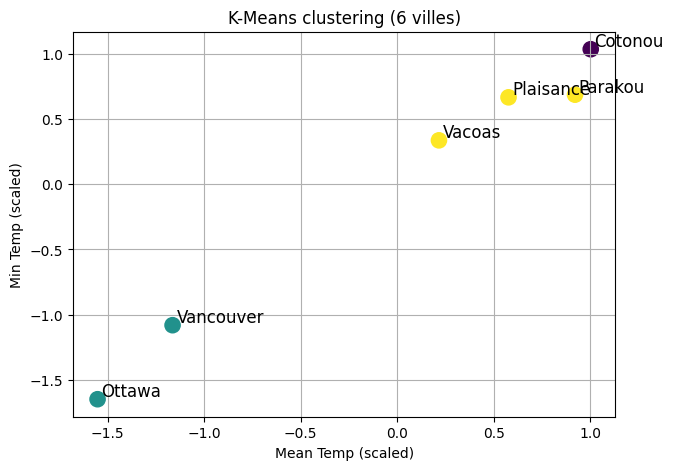

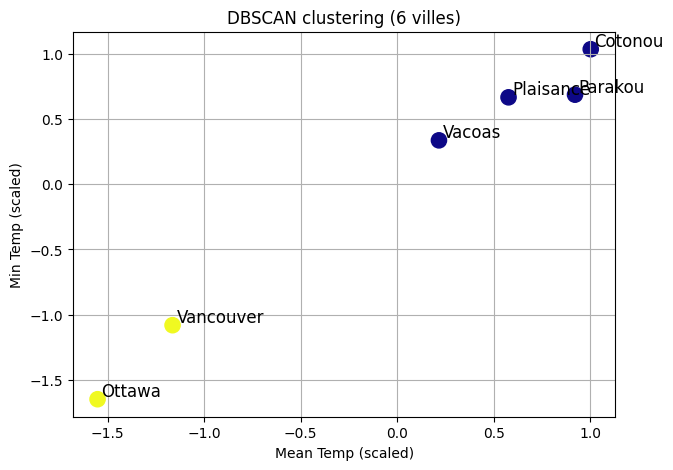

In [50]:
#CLUSTERING – K-Means + DBSCAN

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# 1) Chargement des fichiers  (déjà imputés)
dfs = {
    "Ottawa": pd.read_csv("ottawa_3.csv"),
    "Vancouver": pd.read_csv("vancouver_3.csv"),
    "Cotonou": pd.read_csv("cotonou_clean.csv"),
    "Parakou": pd.read_csv("parakou_clean.csv"),
    "Plaisance": pd.read_csv("plaisance_clean.csv"),
    "Vacoas": pd.read_csv("vacoas_clean.csv")
}

# 2) Colonnes comparables entre toutes les villes
variables = [
    "Mean Temp (°C)",
    "Min Temp (°C)",
    "Max Temp (°C)",
    "Total Precip (mm)",
    "Spd of Max Gust (km/h)"
]

#  3) Calcul des moyennes par ville
df_all = []

for ville, df in dfs.items():
    temp = df[variables].mean().to_frame().T    # Moyennes
    temp["Ville"] = ville                       # Nom de la ville
    df_all.append(temp)

df_all = pd.concat(df_all, ignore_index=True)

print(" Données utilisées pour le clustering :")
display(df_all)

#  4) Normalisation des données
X = df_all[variables].values          # Seulement les valeurs numériques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5) CLUSTERING K-MEANS
kmeans = KMeans(n_clusters=3, random_state=42)
df_all["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)

# 6) CLUSTERING DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=2)
df_all["Cluster_DBSCAN"] = dbscan.fit_predict(X_scaled)

# 7) Affichage des résultats
print("\n Résultats du clustering :")
display(df_all)

# 8) Visualisation K-Means
plt.figure(figsize=(7,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=df_all["Cluster_KMeans"], cmap="viridis", s=120)
for i, v in enumerate(df_all["Ville"]):
    plt.text(X_scaled[i,0]+0.02, X_scaled[i,1]+0.02, v, fontsize=12)
plt.title("K-Means clustering (6 villes)")
plt.xlabel("Mean Temp (scaled)")
plt.ylabel("Min Temp (scaled)")
plt.grid(True)
plt.show()

# 9) Visualisation DBSCAN
plt.figure(figsize=(7,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=df_all["Cluster_DBSCAN"], cmap="plasma", s=120)
for i, v in enumerate(df_all["Ville"]):
    plt.text(X_scaled[i,0]+0.02, X_scaled[i,1]+0.02, v, fontsize=12)
plt.title("DBSCAN clustering (6 villes)")
plt.xlabel("Mean Temp (scaled)")
plt.ylabel("Min Temp (scaled)")
plt.grid(True)
plt.show()


        OTTAWA
 Ottawa — Mean Temp (°C) 


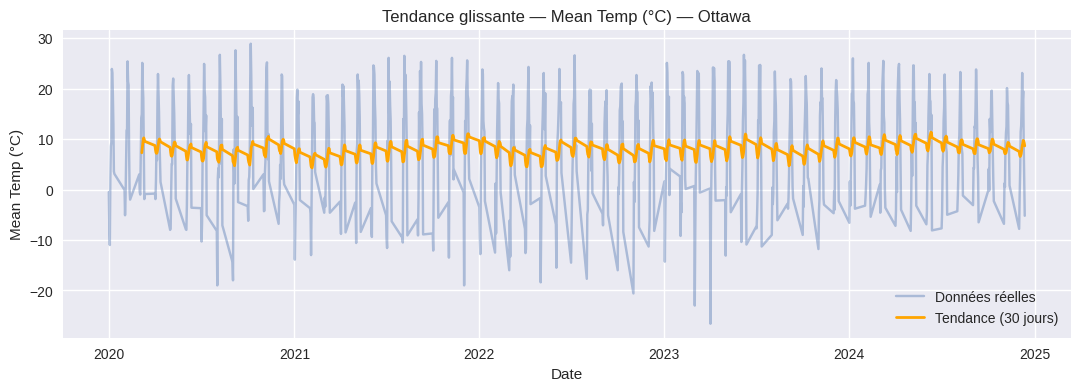

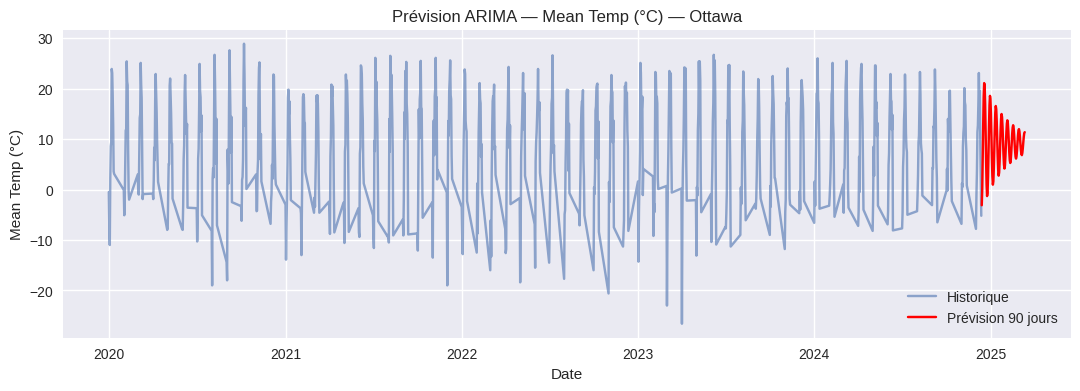

 Ottawa — Min Temp (°C) 


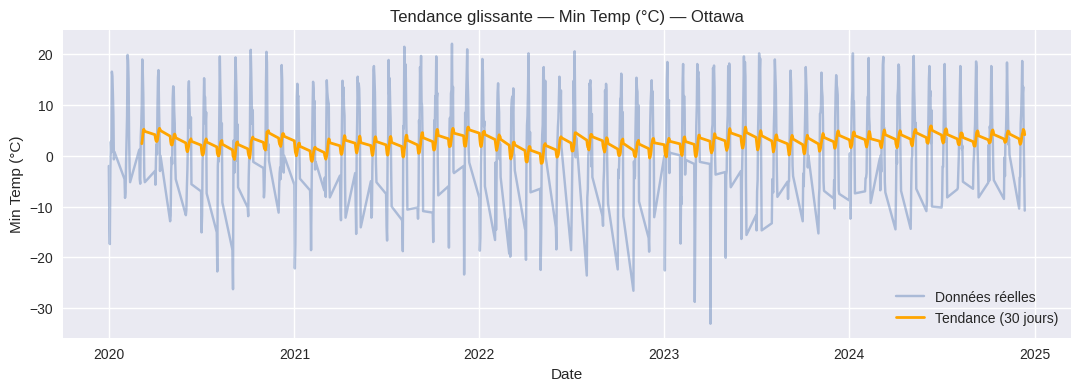

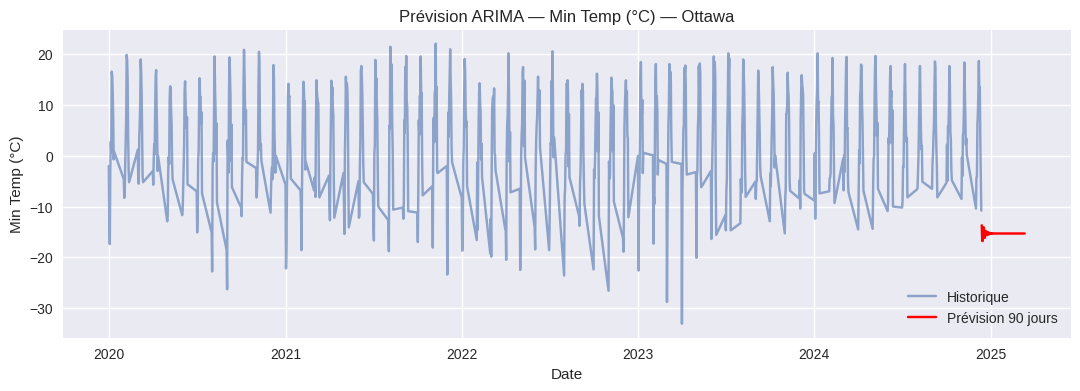

 Ottawa — Max Temp (°C) 


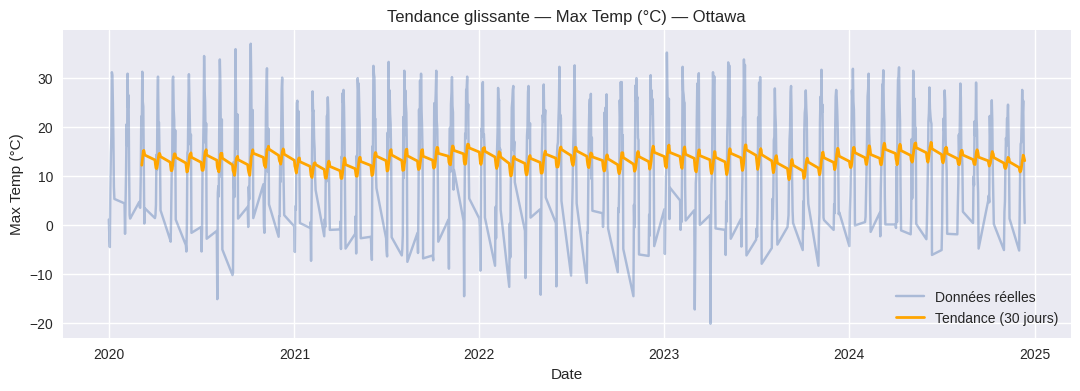

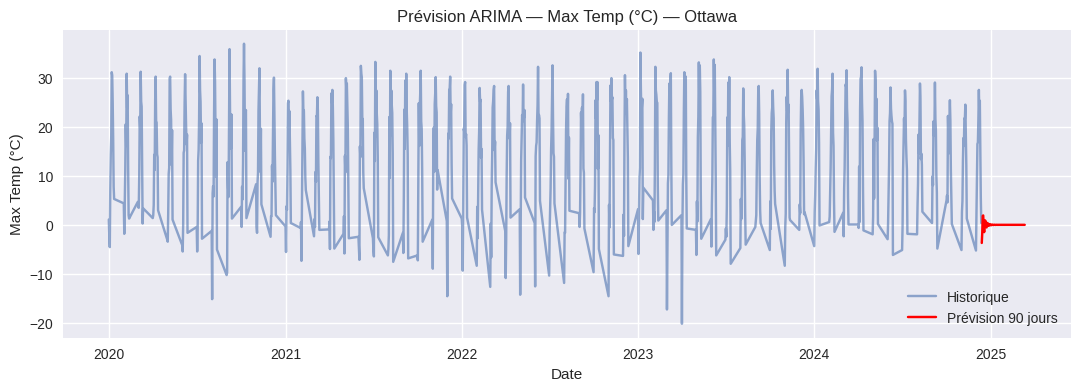

 Ottawa — Total Precip (mm) 


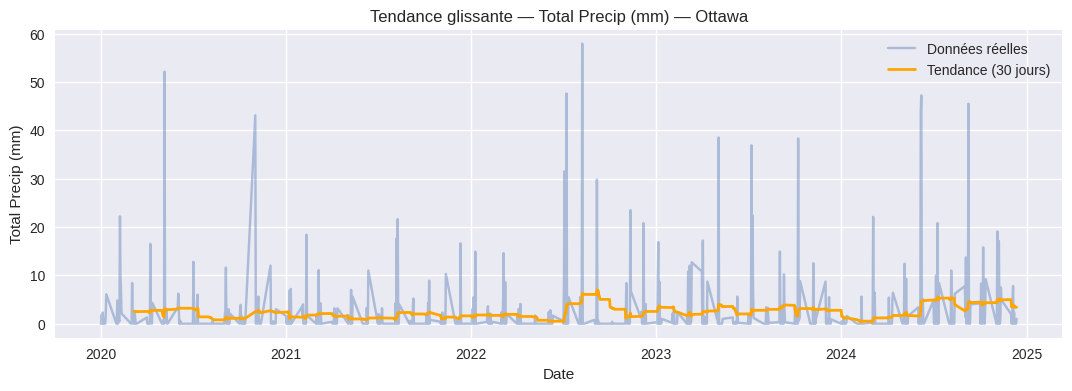

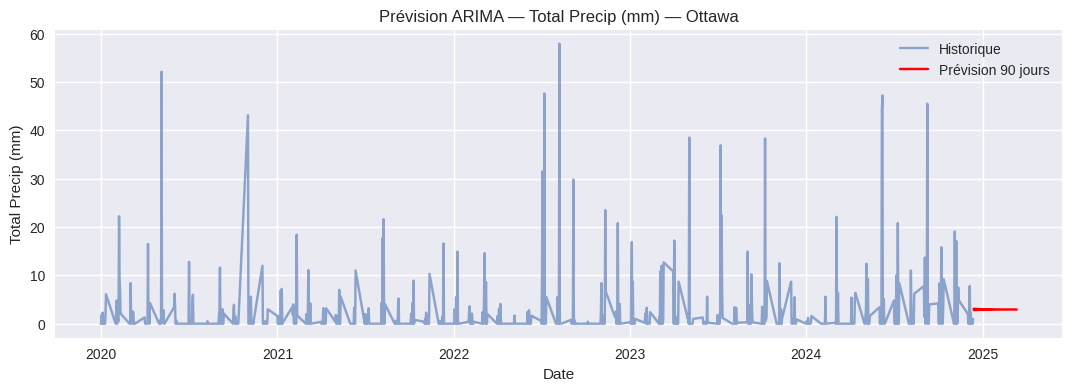

 Ottawa — Spd of Max Gust (km/h) 


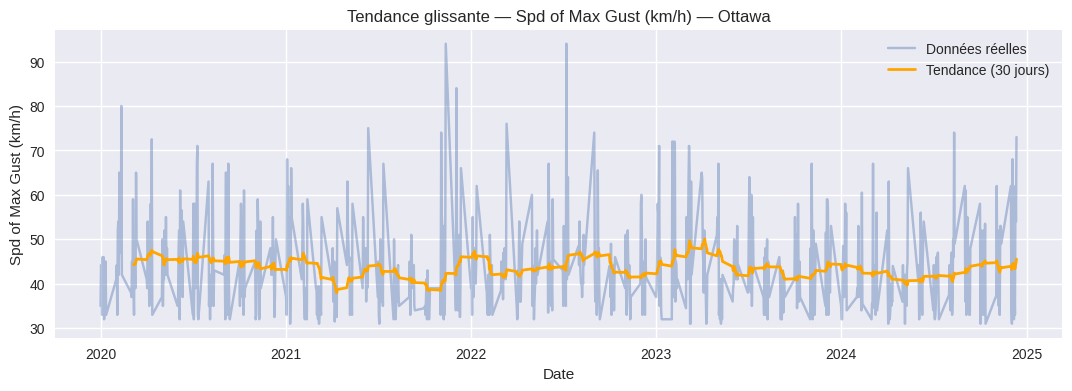

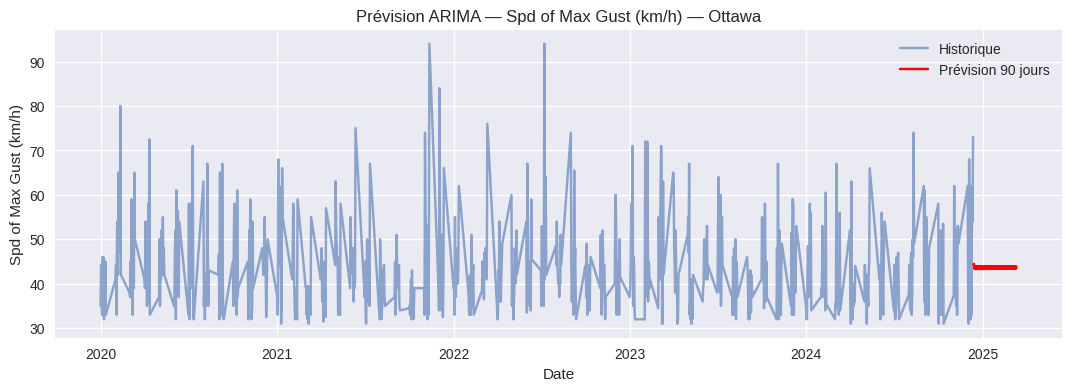

        VANCOUVER
 Vancouver — Mean Temp (°C) 


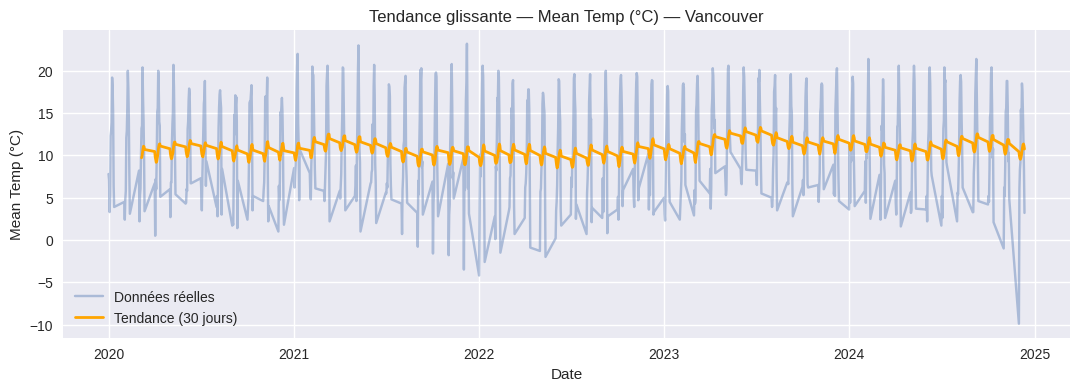

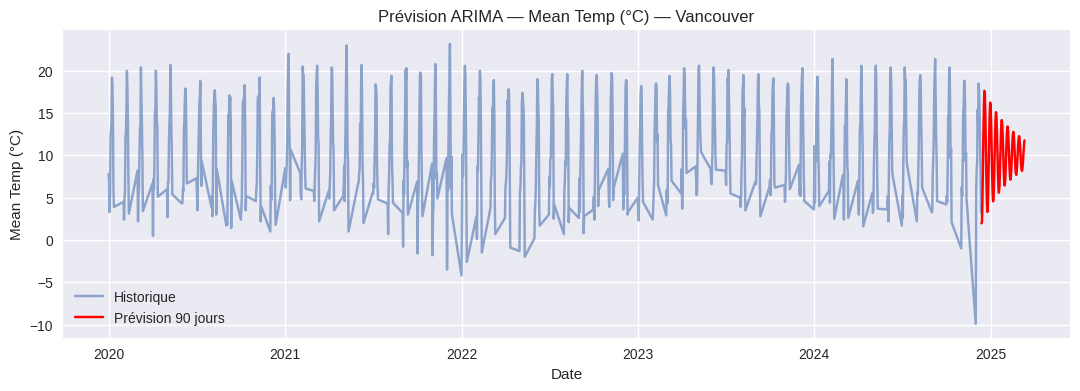

 Vancouver — Min Temp (°C) 


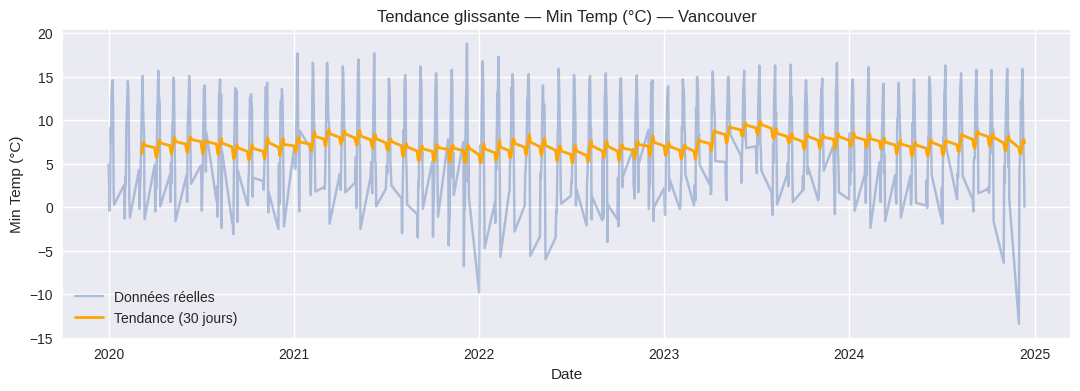

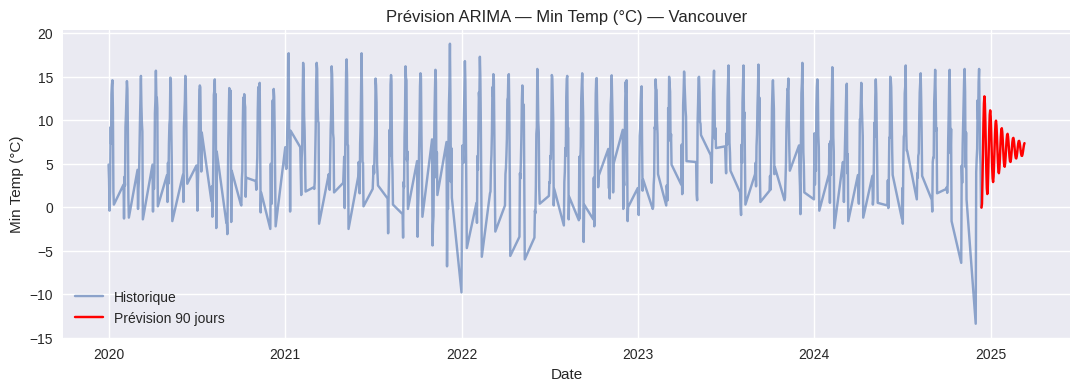

 Vancouver — Max Temp (°C) 


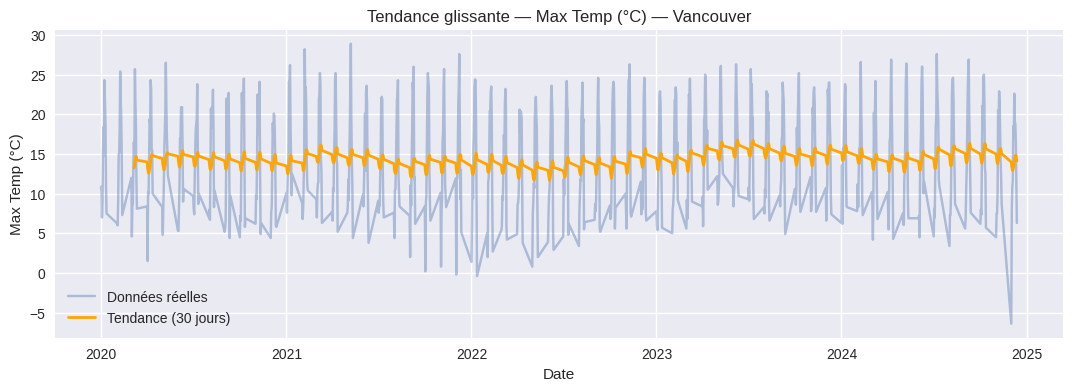

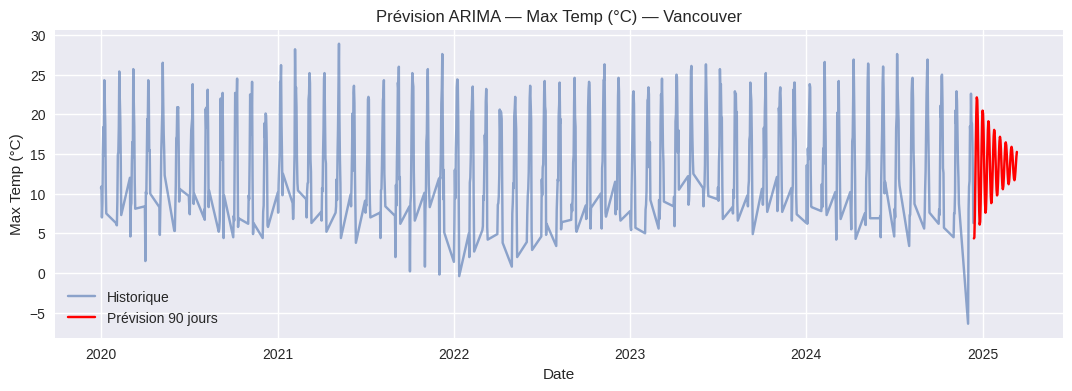

 Vancouver — Total Precip (mm) 


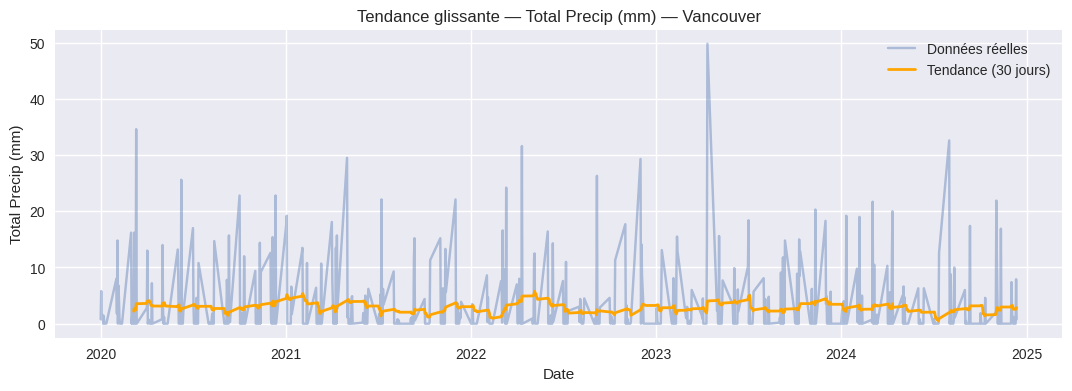

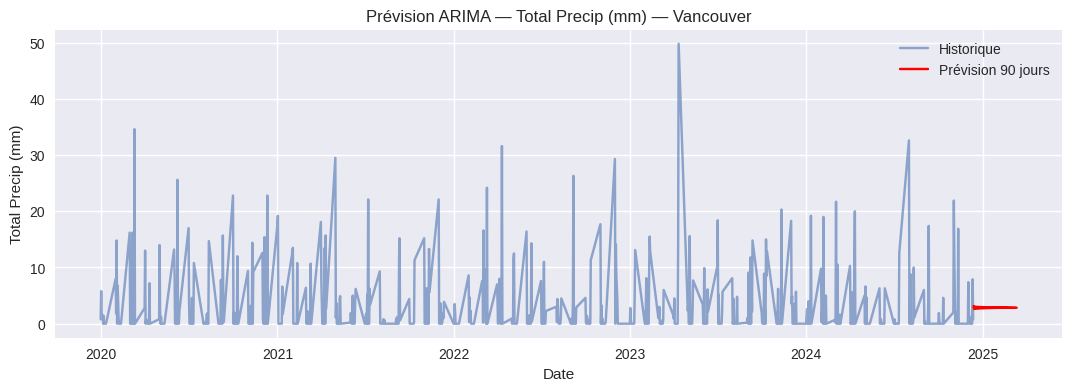

 Vancouver — Spd of Max Gust (km/h) 


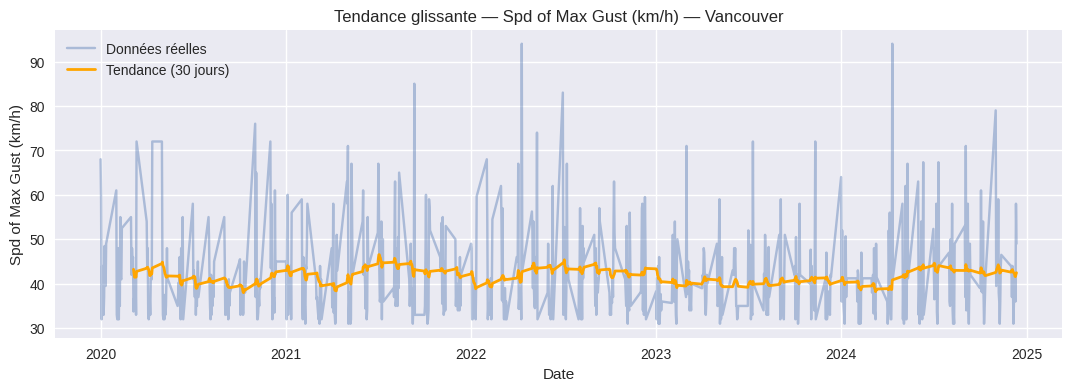

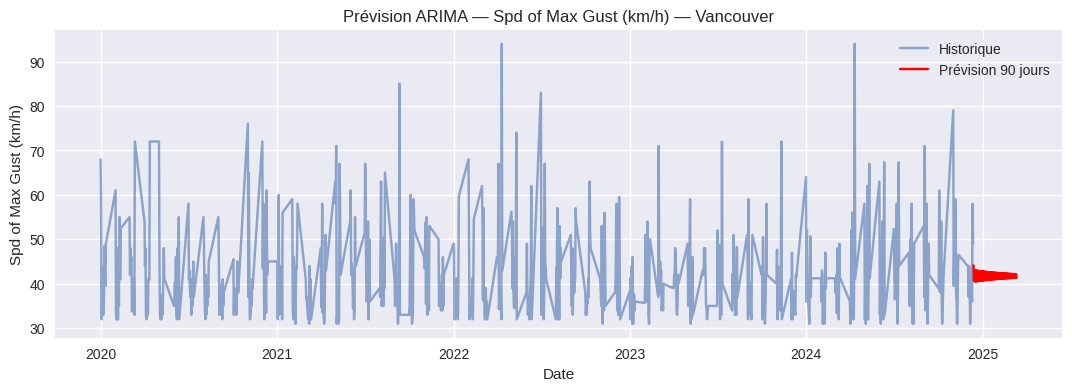

        COTONOU
 Cotonou — Mean Temp (°C) 


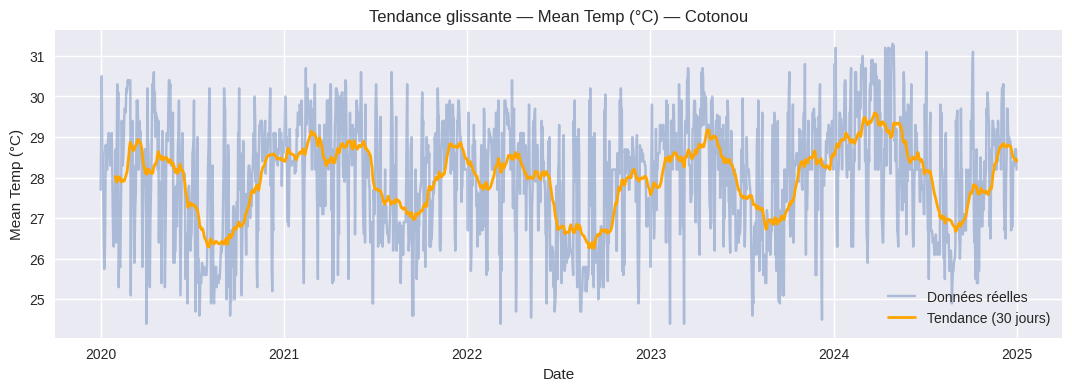

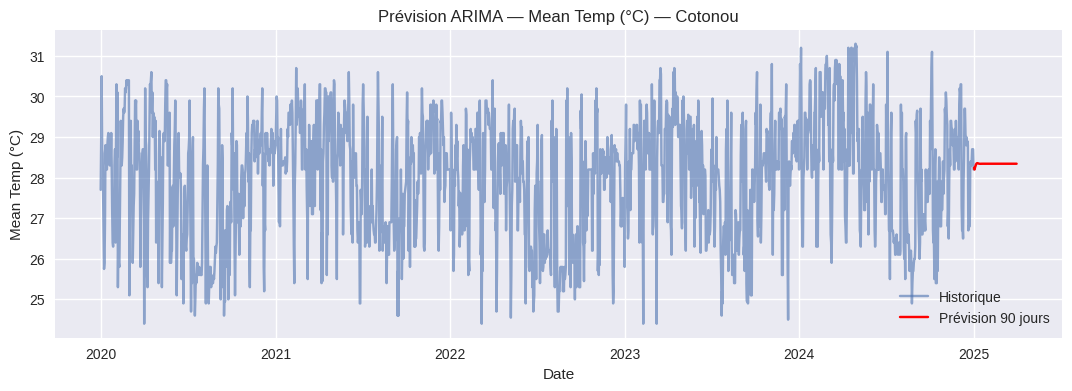

 Cotonou — Min Temp (°C) 


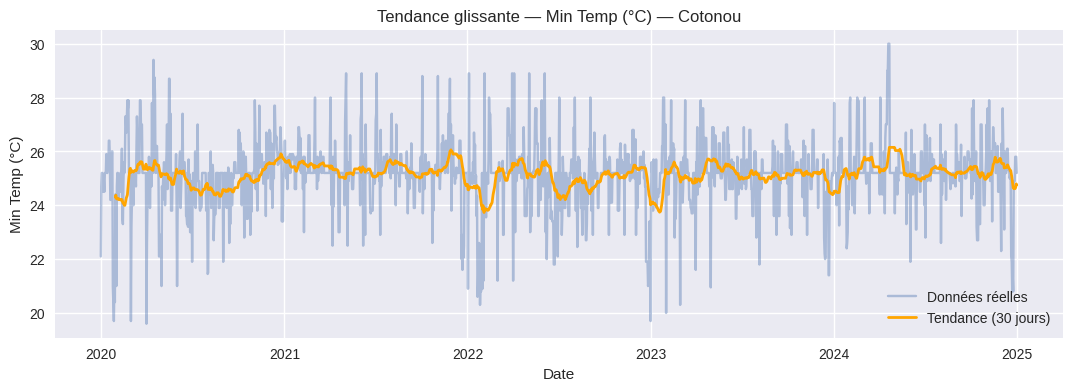

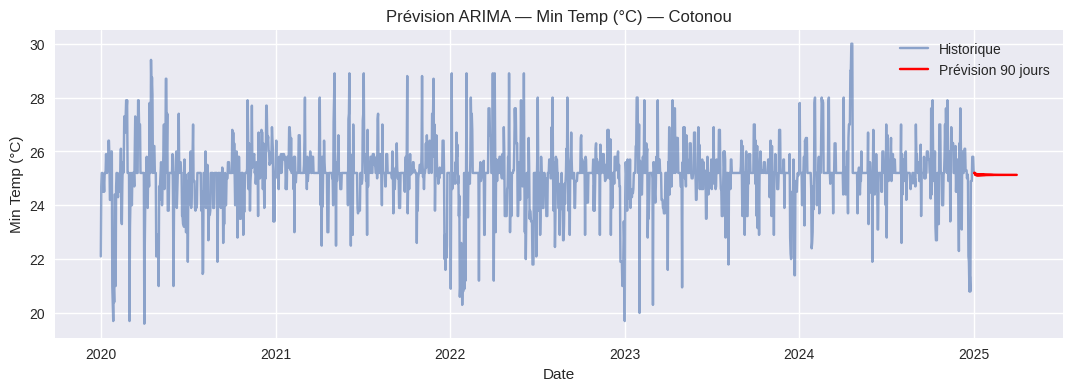

 Cotonou — Max Temp (°C) 


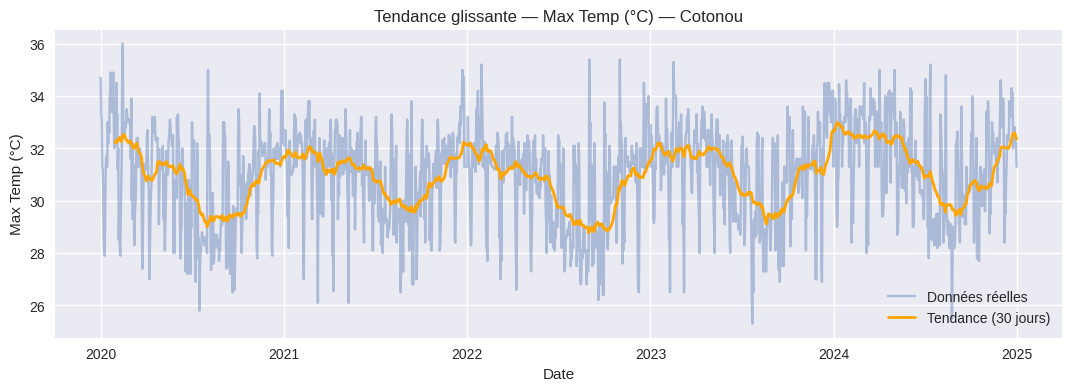

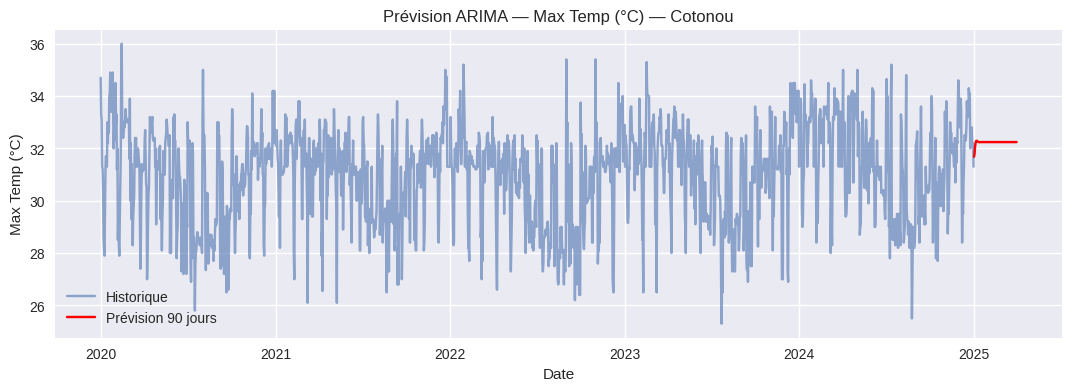

 Cotonou — Total Precip (mm) 


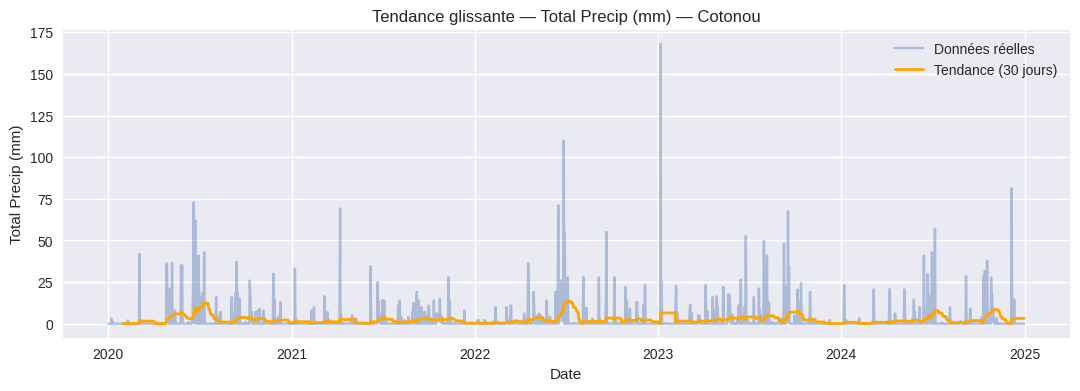

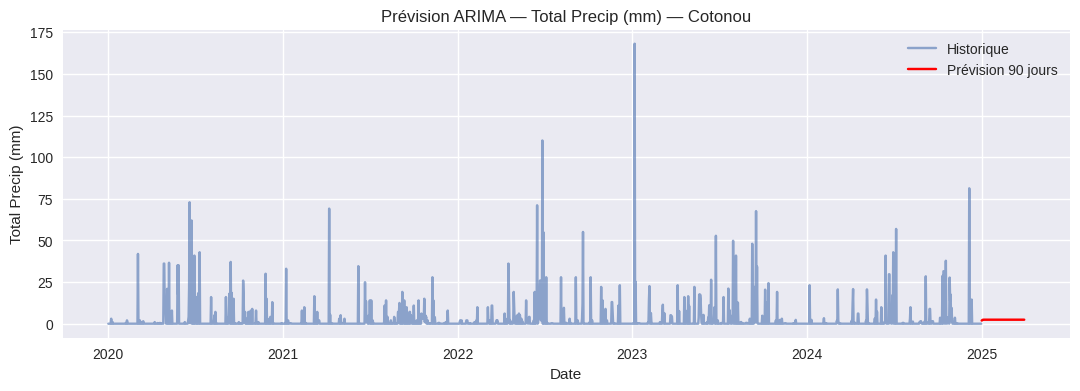

 Cotonou — Spd of Max Gust (km/h) 


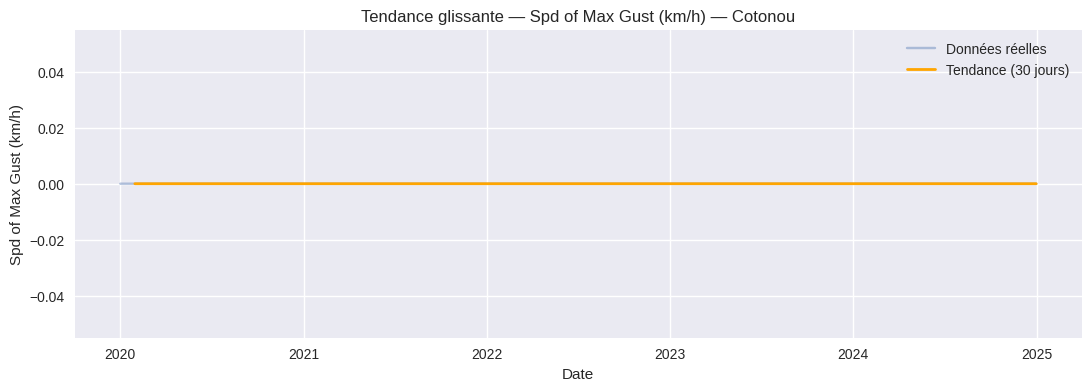

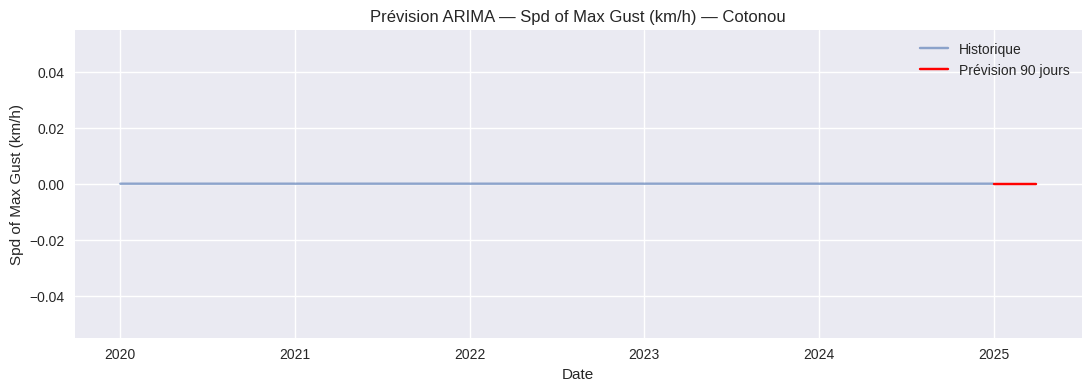

        PARAKOU
 Parakou — Mean Temp (°C) 


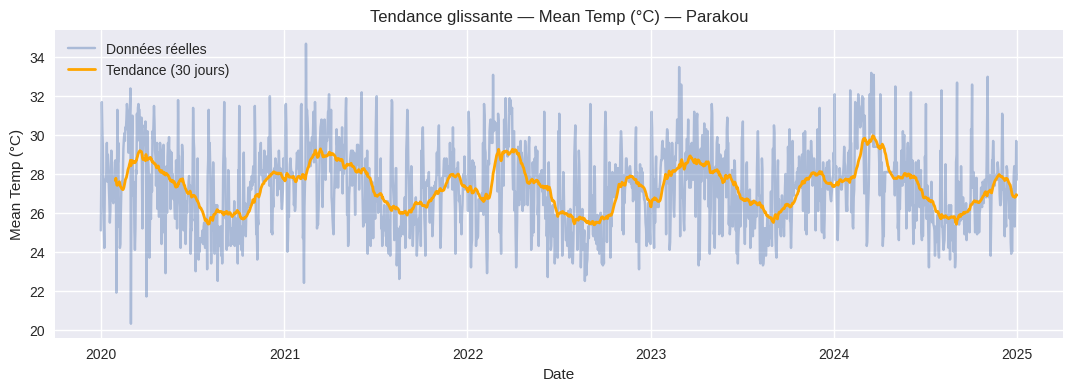

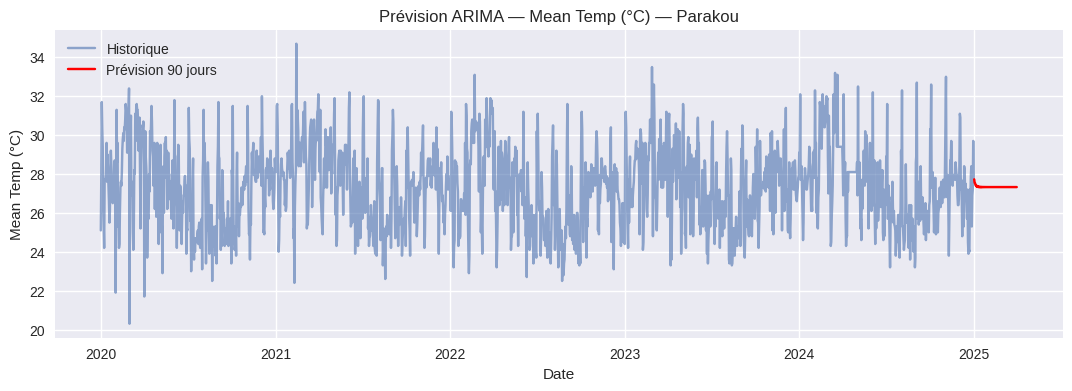

 Parakou — Min Temp (°C) 


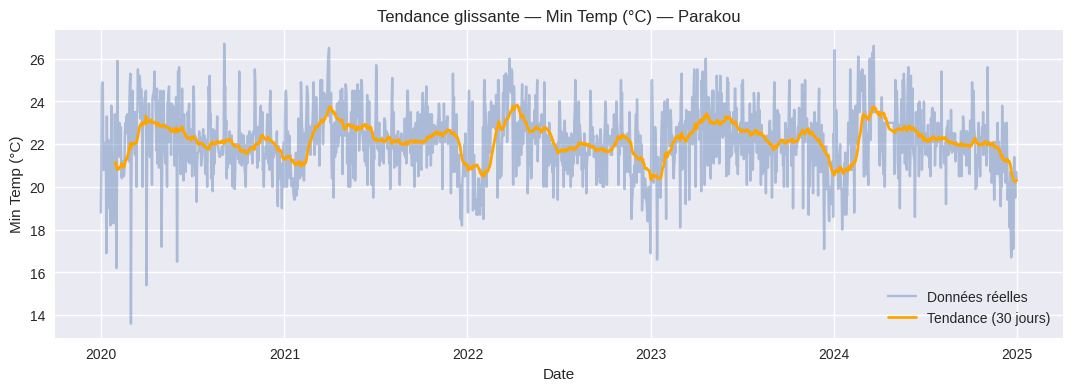

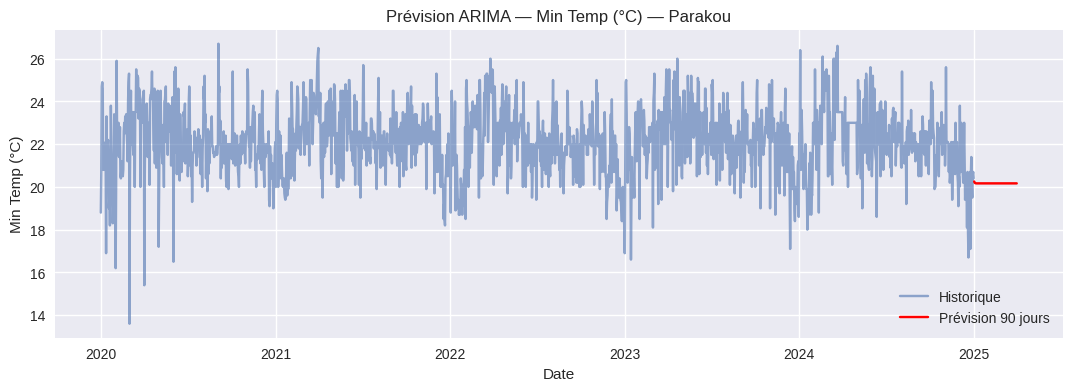

 Parakou — Max Temp (°C) 


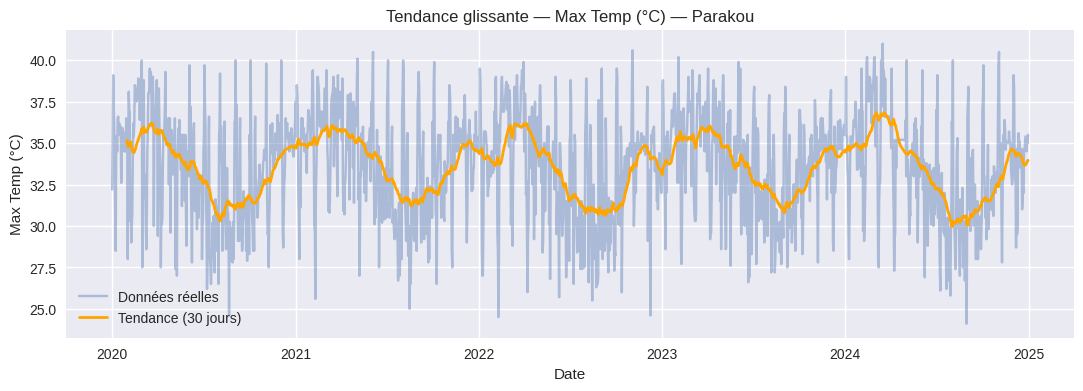

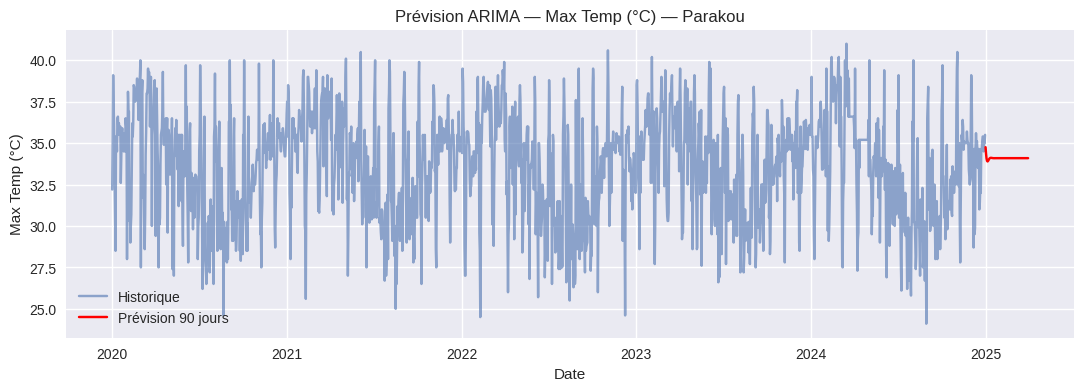

 Parakou — Total Precip (mm) 


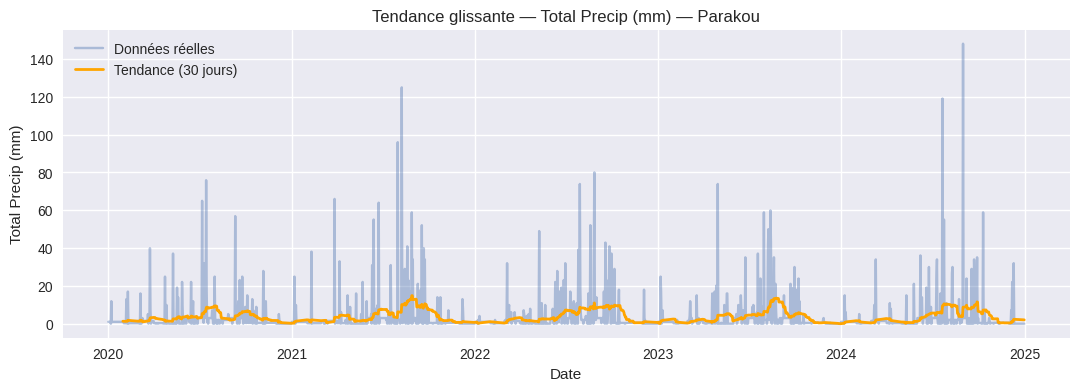

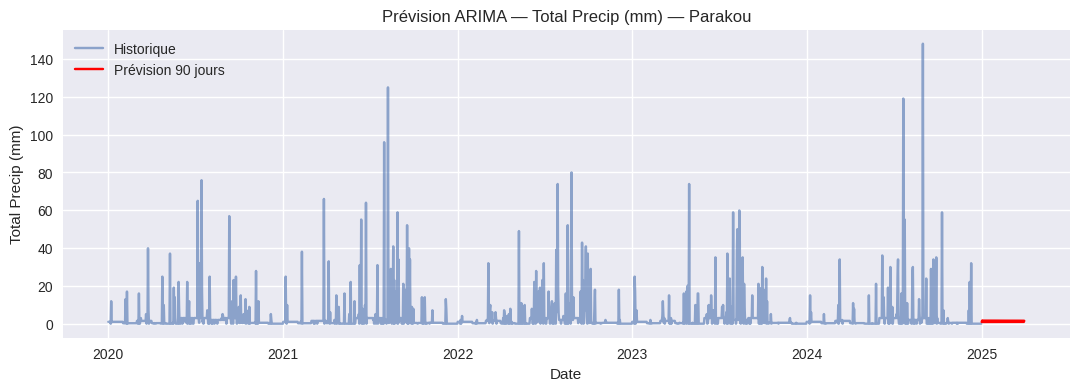

 Parakou — Spd of Max Gust (km/h) 


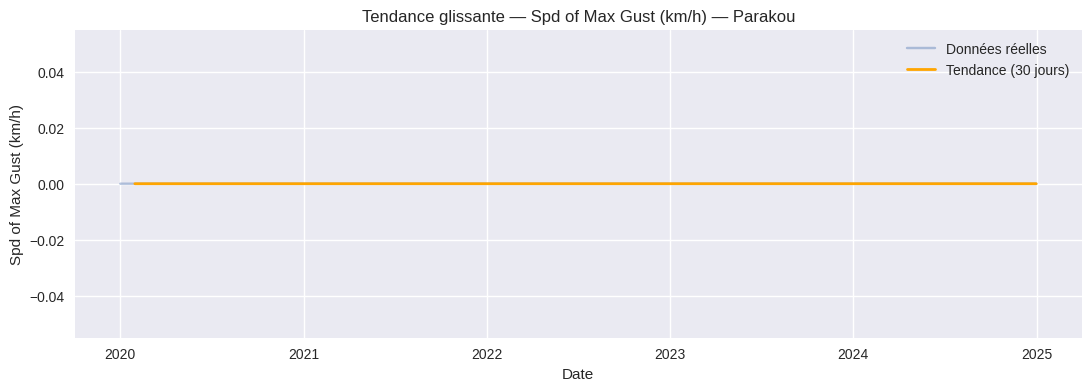

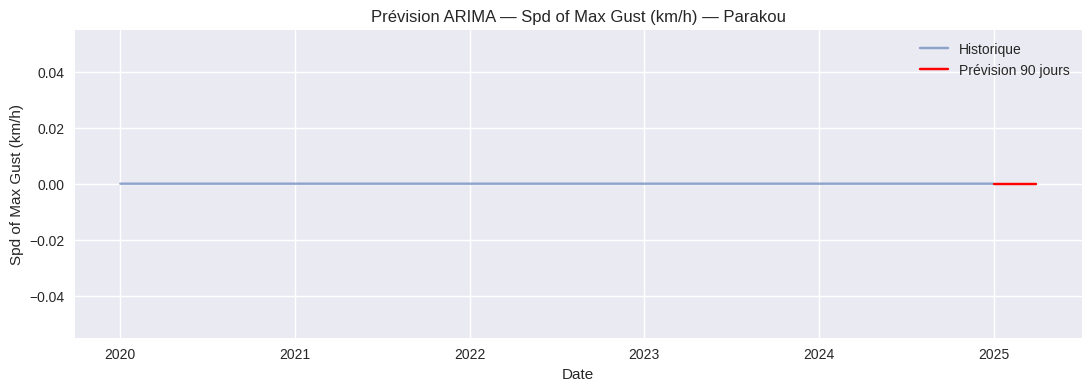

        PLAISANCE
 Plaisance — Mean Temp (°C) 


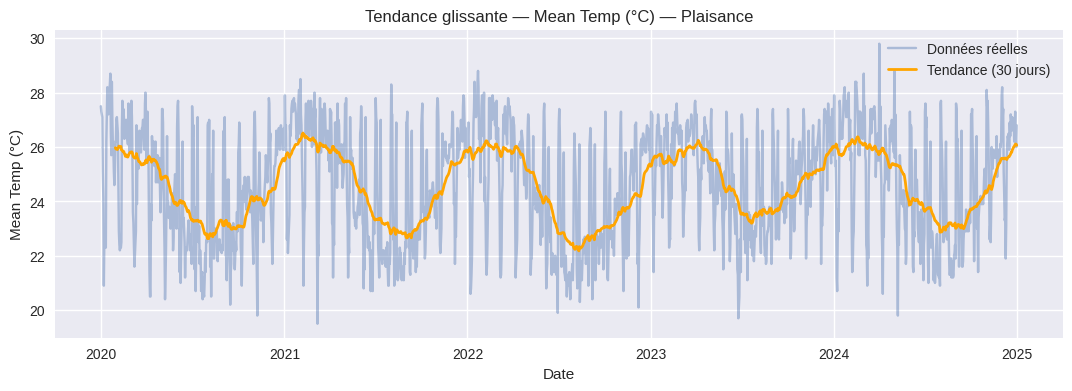

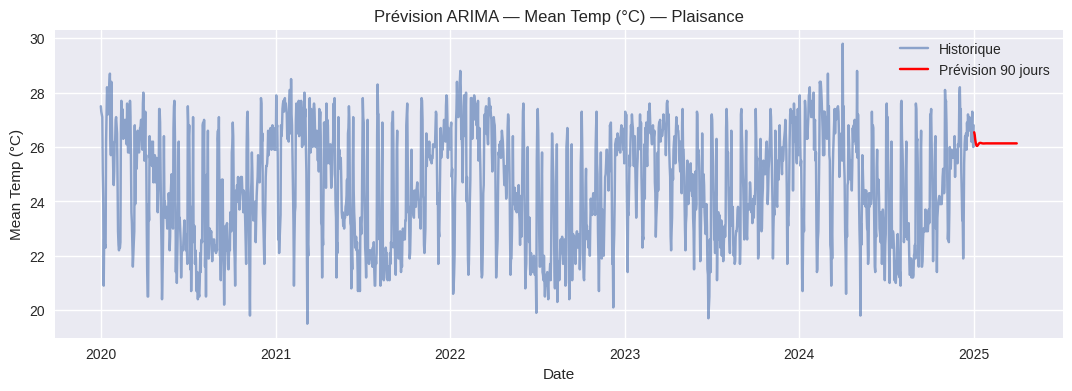

 Plaisance — Min Temp (°C) 


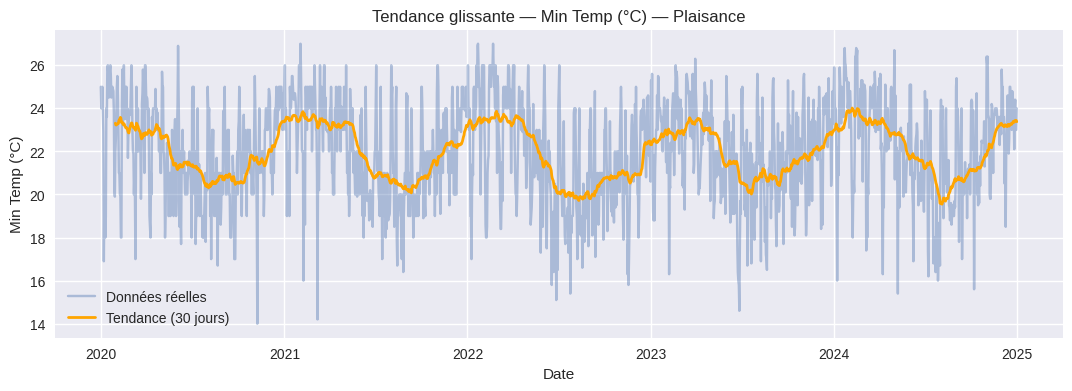

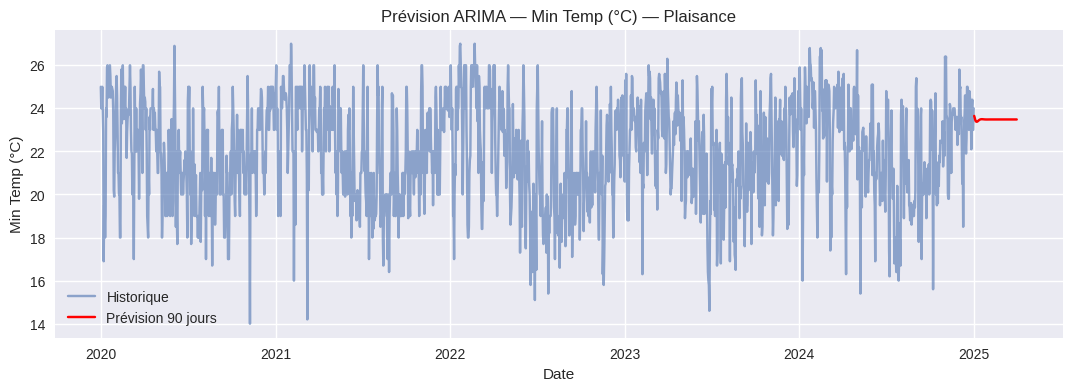

 Plaisance — Max Temp (°C) 


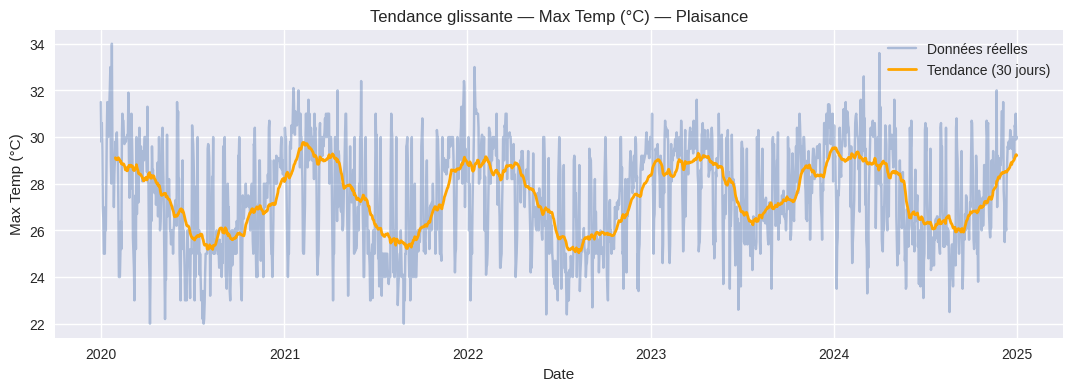

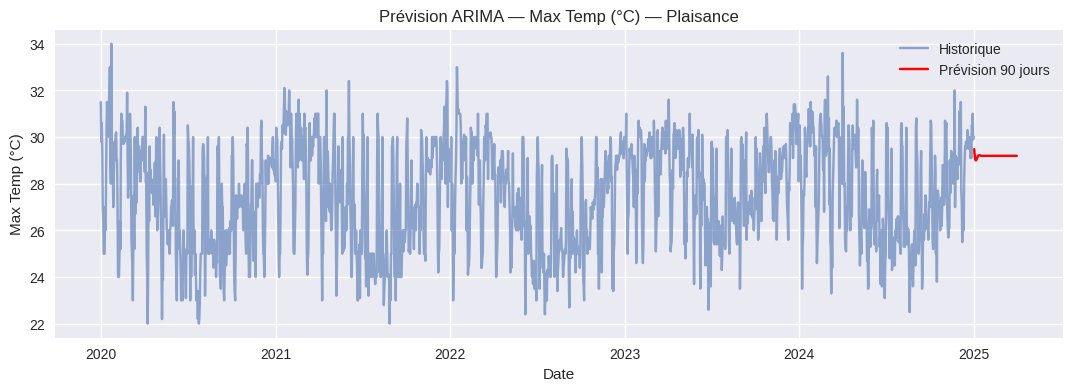

 Plaisance — Total Precip (mm) 


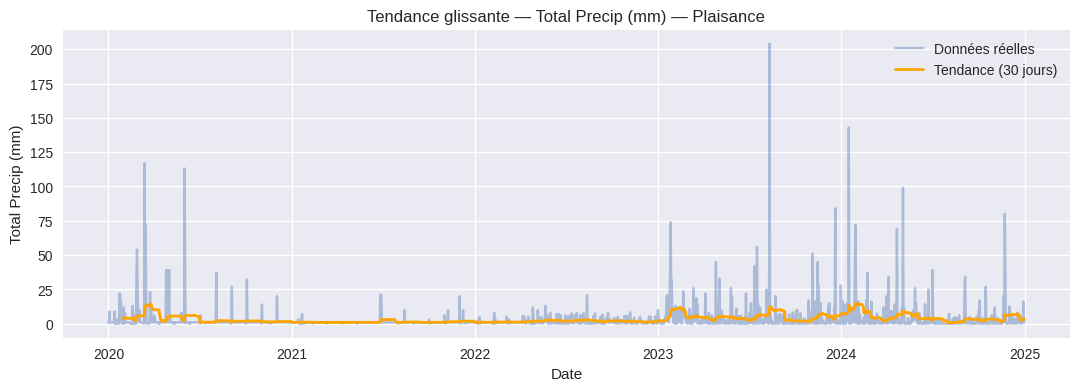

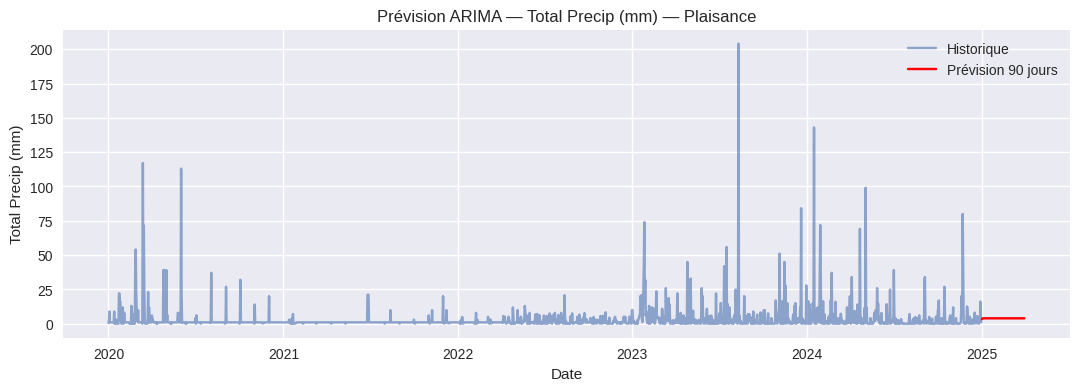

 Plaisance — Spd of Max Gust (km/h) 


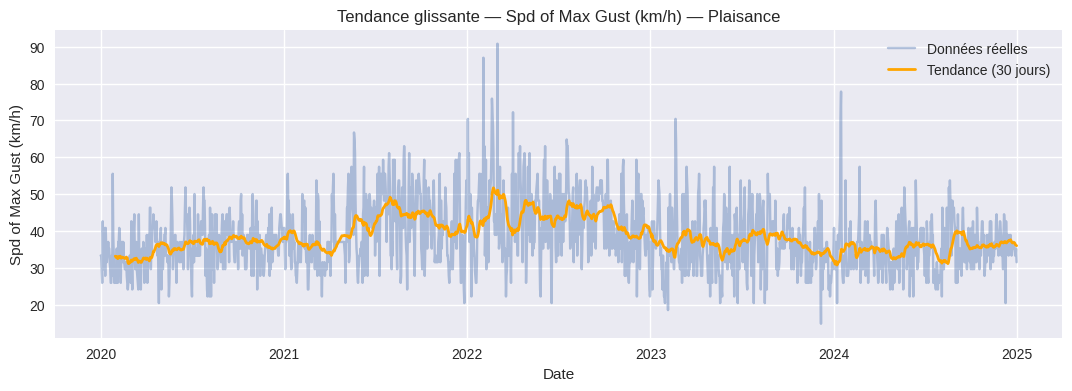

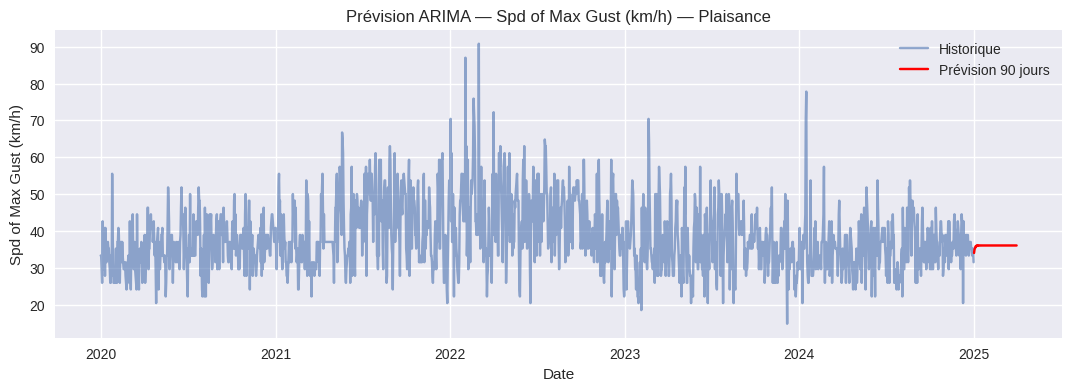

        VACOAS
 Vacoas — Mean Temp (°C) 


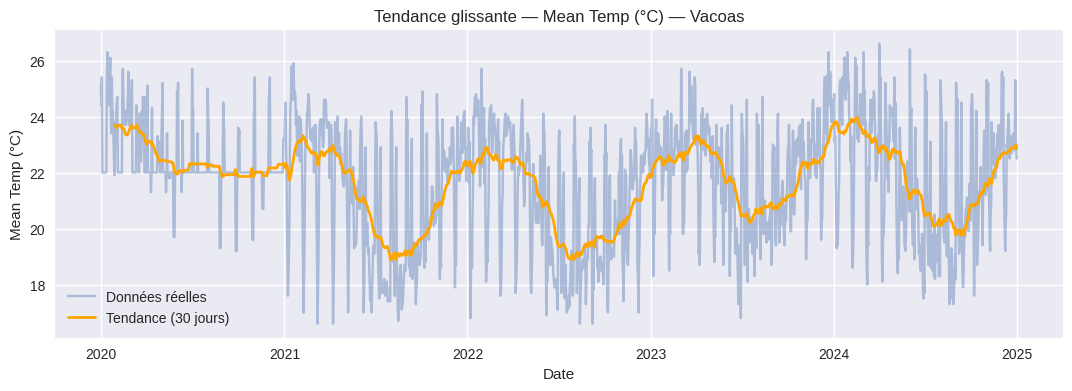

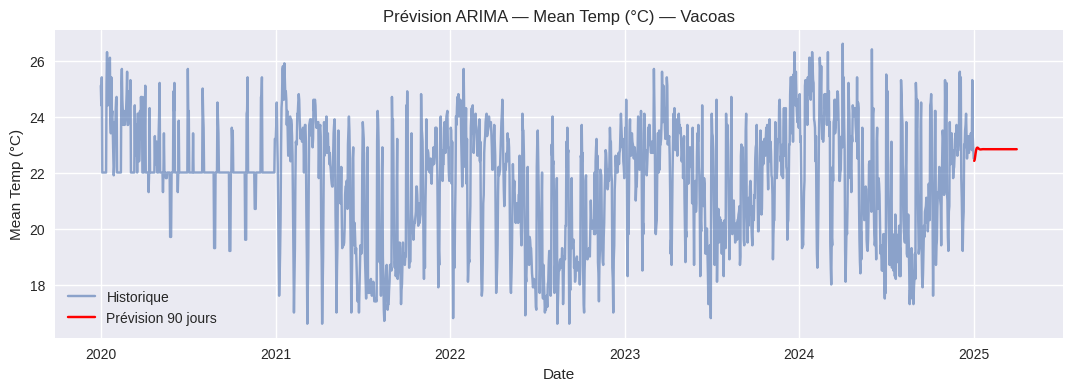

 Vacoas — Min Temp (°C) 


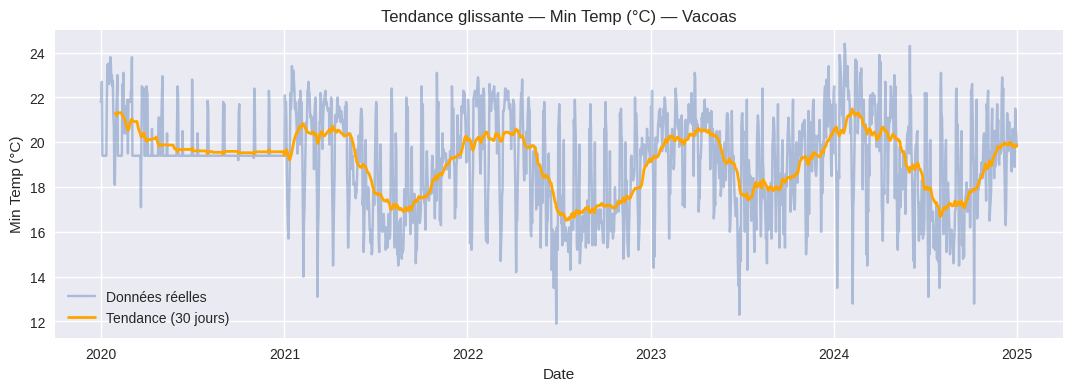

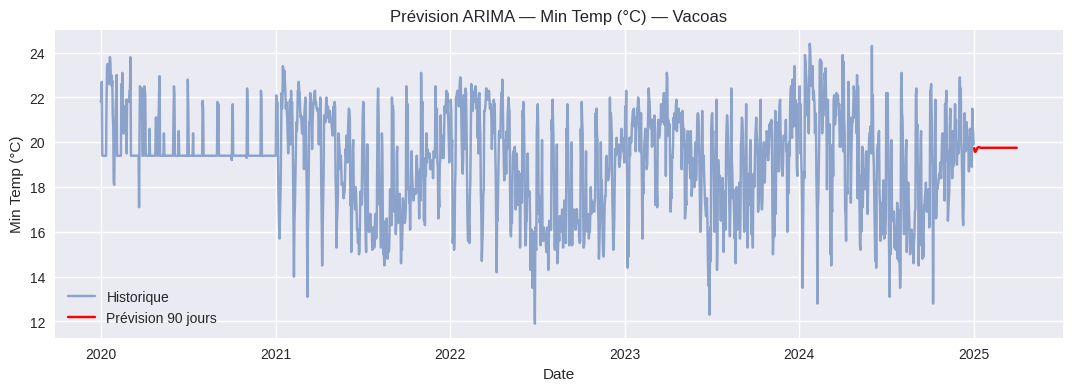

 Vacoas — Max Temp (°C) 


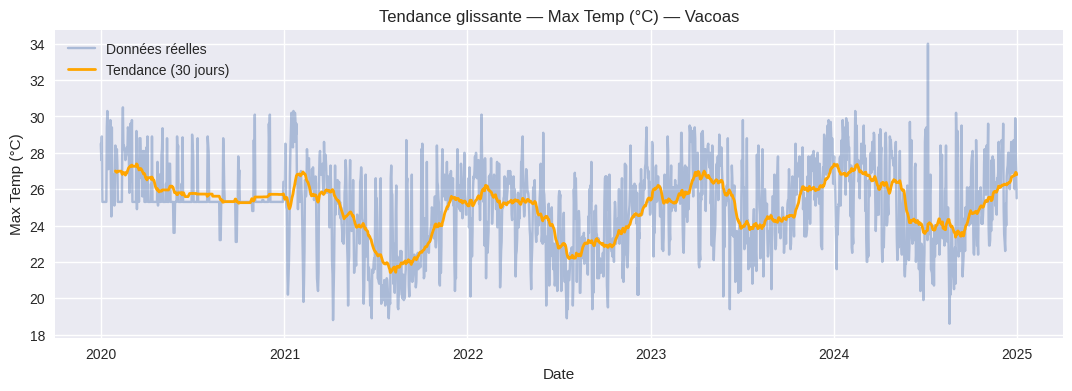

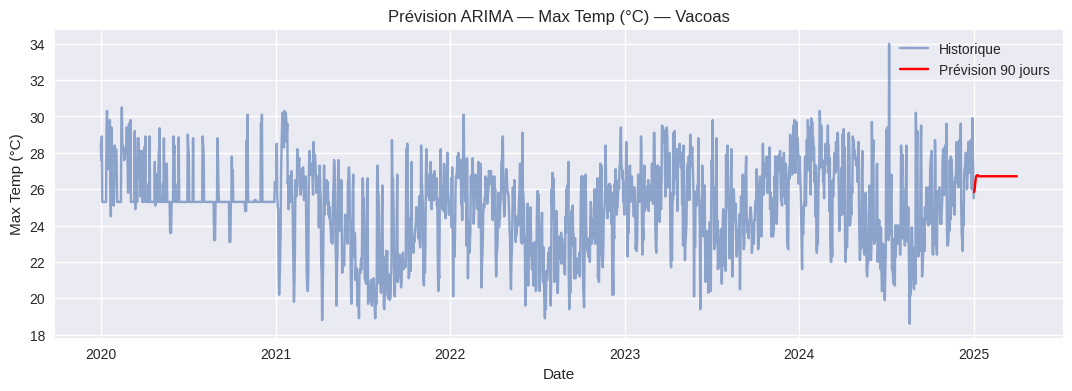

 Vacoas — Total Precip (mm) 


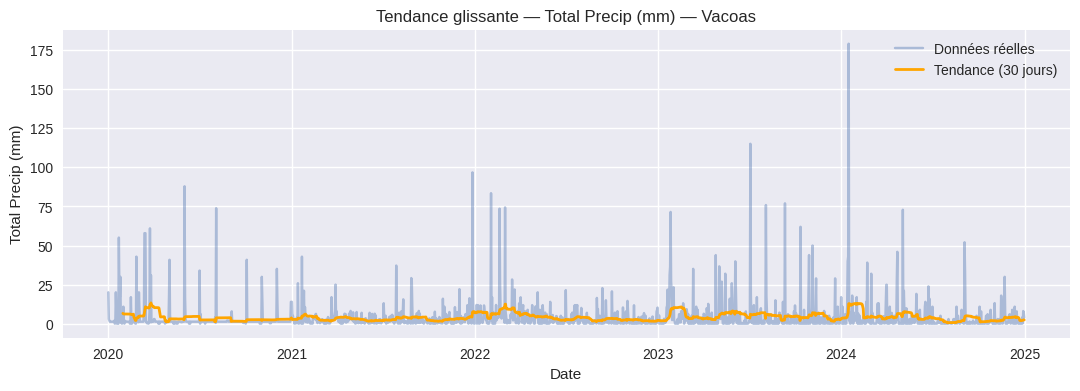

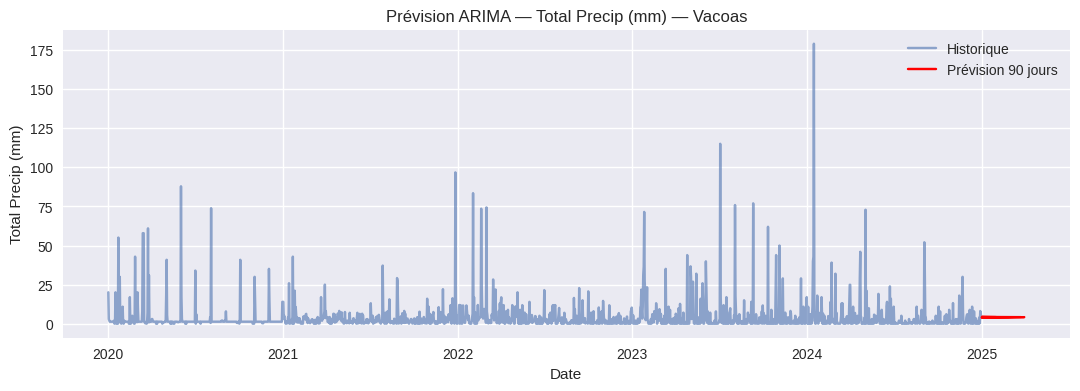

 Vacoas — Spd of Max Gust (km/h) 


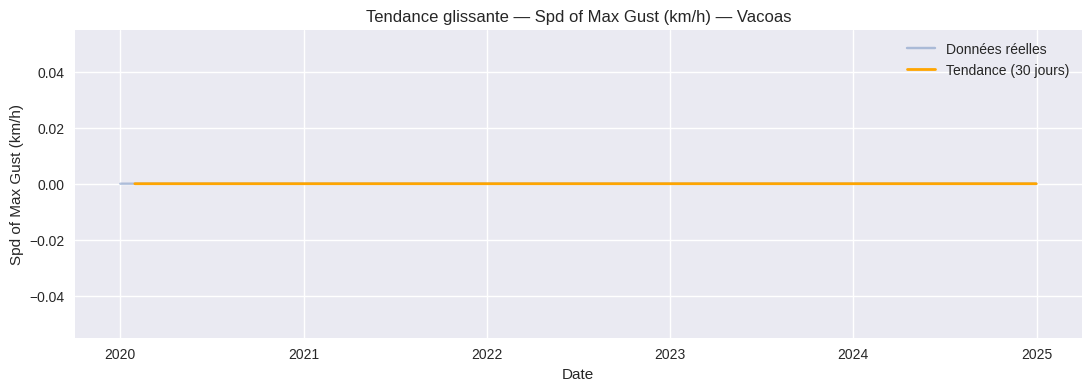

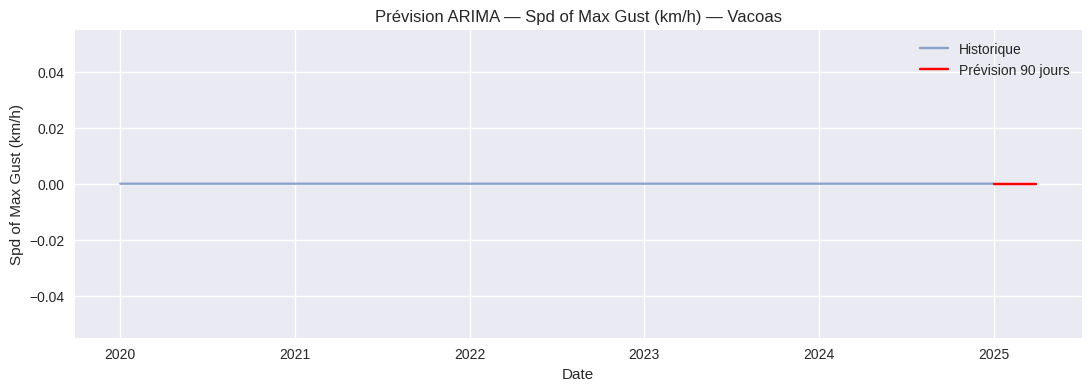

In [58]:

#  SÉRIES TEMPORELLES — TENDANCES + PRÉVISIONS (ARIMA)
#  POUR TOUTES LES VILLES ET TOUTES LES VARIABLES

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
plt.style.use("seaborn-v0_8")

# 1) CHARGEMENT DES DONNÉES
dfs = {
    "Ottawa": pd.read_csv("ottawa_3.csv"),
    "Vancouver": pd.read_csv("vancouver_3.csv"),
    "Cotonou": pd.read_csv("cotonou_clean.csv"),
    "Parakou": pd.read_csv("parakou_clean.csv"),
    "Plaisance": pd.read_csv("plaisance_clean.csv"),
    "Vacoas": pd.read_csv("vacoas_clean.csv")
}

# Conversion + nettoyage
for name, df in dfs.items():
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")  # convertit tout
    df = df.dropna(subset=["Date"])  # enlève lignes avec date NaT
    df.sort_values("Date", inplace=True)
    dfs[name] = df

# 2) VARIABLES CLIMATIQUES
variables = [
    "Mean Temp (°C)",
    "Min Temp (°C)",
    "Max Temp (°C)",
    "Total Precip (mm)",
    "Spd of Max Gust (km/h)"
]

# 3) FONCTION — TENDANCE GLISSANTE
def plot_tendance(df, ville, variable, window=30):
    plt.figure(figsize=(13,4))

    plt.plot(df["Date"], df[variable], label="Données réelles", alpha=0.4)
    plt.plot(df["Date"], df[variable].rolling(window).mean(),
             label=f"Tendance ({window} jours)", color="orange", linewidth=2)

    plt.title(f"Tendance glissante — {variable} — {ville}")
    plt.xlabel("Date")
    plt.ylabel(variable)
    plt.legend()
    plt.grid(True)
    plt.show()


# 4) FONCTION — PRÉVISIONS ARIMA
def plot_previsions(df, ville, variable, horizon=90):
    ts = df.set_index("Date")[variable].astype(float)

    # Modèle ARIMA simple mais fiable
    model = ARIMA(ts, order=(3,1,2))
    model_fit = model.fit()

    # Prévision
    forecast = model_fit.forecast(steps=horizon)
    future_dates = pd.date_range(start=ts.index[-1], periods=horizon+1, freq="D")[1:]

    plt.figure(figsize=(13,4))
    plt.plot(ts.index, ts, label="Historique", alpha=0.6)
    plt.plot(future_dates, forecast, color="red", label=f"Prévision {horizon} jours")

    plt.title(f"Prévision ARIMA — {variable} — {ville}")
    plt.xlabel("Date")
    plt.ylabel(variable)
    plt.legend()
    plt.grid(True)
    plt.show()

# 5) EXÉCUTION — TOUTES LES VILLES + VARIABLES
for ville, df in dfs.items():
    print(f"        {ville.upper()}")

    for var in variables:
        if var not in df.columns:
            print(f" {var} non disponible pour {ville}")
            continue

        print(f" {ville} — {var} ")

        try:
            plot_tendance(df, ville, var)
            plot_previsions(df, ville, var)
        except Exception as e:
            print(f" Erreur pour {ville} — {var} : {e}")
